<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2_WISDM_smartwatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
#import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [ ]:
dataset_path = 'Wisdm smartwatch'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [ ]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = True
aggregate_falls = True
use_speed=False
use_total_speed=False
use_timestamp=False
use_squared_components=False
use_squared_speed=True
use_sign_speed=False
use_position=False

In [ ]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [ ]:
batchsize = 512       ############

In [ ]:
from os import mkdir
mkdir(folder_name)

In [ ]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# WISDM Dataset

In [ ]:
classes_to_rename = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

In [ ]:
classes_to_consider = ['walking','jogging','stairs','sitting','standing',
    'typing', 'teeth','soup','chips','pasta','drinking','sandwich',
    'kicking','catch','dribbling','writing', 'clapping','folding']

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1600,1650):

    df1 = pd.read_csv(f'wisdm-dataset/raw/watch/accel/data_{i}_accel_watch.txt', header=None, sep=',')
    #df1 = df1.loc[:, [0,1,2,3,4,5]]
    df1 = df1.rename(columns={
         0: 'user_id', 1: 'activity', 2: 'timestamp',
             3:'x_axis', 4: 'y_axis', 5: 'z_axis'
        })
    df = pd.concat([df,df1])

In [ ]:
df['z_axis'] = df['z_axis'].str.replace('\;*$', '', regex=True)
#df['z_axis'].apply(lambda x: float(x))
df['z_axis'] = df['z_axis'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3710454 entries, 0 to 65165
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   activity   object 
 2   timestamp  int64  
 3   x_axis     float64
 4   y_axis     float64
 5   z_axis     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 198.2+ MB


# Caricamento dati

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
activity     0
timestamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

user_id activity       timestamp    x_axis    y_axis     z_axis
0     1600        A  90426708196641  7.091625 -0.591667   8.195502
1     1600        A  90426757696641  4.972757 -0.158317   6.696732
2     1600        A  90426807196641  3.253720 -0.191835   6.107758
3     1600        A  90426856696641  2.801216 -0.155922   5.997625
4     1600        A  90426906196641  3.770868 -1.051354   7.731027
5     1600        A  90426955696641  4.661511  0.169689   9.684695
6     1600        A  90427005196641  6.145916  0.832883  11.003901
7     1600        A  90427054696641  7.259220 -0.792780  11.485135
8     1600        A  90427104196641  7.354988 -2.535759  11.454011
9     1600        A  90427153696641  7.319075 -2.700959  11.461193

In [ ]:
df.sample(10)

user_id activity         timestamp     x_axis     y_axis       z_axis
101893     1629        K   379321564632449   3.397971  -7.316980   5.4617724;
40871      1628        J   912033330976107   3.517382   8.925284  -2.4628854;
51238      1612        P     7416767220606   2.814833 -12.155811    6.133945;
51060      1613        P   615955665554223  16.543634   9.867253  -1.4404116;
35549      1643        J   711697425727713  -4.135086  -5.862652    5.199907;
28658      1648        H  2529817622824177   8.890120  -3.937414  0.61650693;
57921      1649        Q  2720839886399455  -0.043545 -11.046398  0.07451953;
35580      1610        J    18181605516702  -1.359308  -7.120954   6.2744546;
38203      1621        I   180211771725794  -9.466824  -1.331775  -2.0376153;
63016      1649        S  2721172785907260   8.187721  -8.695291  -3.0116065;

In [ ]:
df.describe()

user_id     timestamp        x_axis        y_axis        z_axis
count  3.710454e+06  3.710454e+06  3.710454e+06  3.710454e+06  3.710454e+06
mean   1.625943e+03  5.745507e+14  3.638343e-01 -4.481287e+00  1.816124e+00
std    1.418875e+01  6.386690e+14  6.956401e+00  5.336952e+00  5.222991e+00
min    1.600000e+03  1.622154e+12 -7.063152e+01 -7.847761e+01 -7.847761e+01
25%    1.614000e+03  8.334468e+13 -4.913500e+00 -8.056937e+00 -1.188721e+00
50%    1.628000e+03  3.490777e+14 -4.224270e-01 -4.582652e+00  1.762132e+00
75%    1.638000e+03  8.564335e+14  5.657761e+00 -1.585111e+00  5.417779e+00
max    1.649000e+03  2.724599e+15  5.211323e+01  3.560197e+01  6.661507e+01

In [ ]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
df.sample(10)

user_id  activity         timestamp     x_axis    y_axis       z_axis
3007437     1640    typing   168074316741000   1.904041 -3.194956   -8.947793;
883955      1613     chips   614450455639521  -6.804621 -6.674286  0.86759883;
3527081     1647   sitting   726041302340550  -1.798345 -3.694104     8.59249;
513539      1607   writing   113957094075165  -0.585233 -8.865729   3.5019689;
2634875     1637  clapping    10988704940000   8.868757 -2.509981    4.598438;
3426282     1645  sandwich  1132620383891536  -1.090709 -3.804536    8.690803;
499999      1607  sandwich   118206614792130   9.553015 -1.423203   2.7907414;
870621      1613  standing   612615964904168   2.949357 -3.722235   8.6774845;
1775601     1626   folding   370840380154281 -10.235662 -0.216376   2.5219922;
547203      1608     teeth   726183417468174  -7.560889 -6.375011   5.5027733;

In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

user_id   activity         timestamp     x_axis    y_axis    z_axis  \
3027087     1640       soup   169618924129000  -8.483160 -0.881367 -3.798501   
1918701     1629    jogging   901624410644509  13.814693  3.383905  1.032051   
3454999     1646    jogging  1470295000550304   4.833594  3.339014 -0.558897   
3542927     1647       soup   730079762283980  -9.640702 -0.817620  1.978509   
3461703     1646    sitting  1466306946096159   4.677223 -1.857900  8.485201   
3031083     1640       soup   169699453878000  -8.610096 -0.730481 -3.659590   
3317422     1644    jogging  1821831382879316   5.303755 -3.105729 -0.784251   
617582      1609       soup   856368183498341  -3.541623 -2.016666  7.311294   
3555456     1647   sandwich   730425667397779  -8.999056 -1.028310  3.654450   
2226118     1632  dribbling     7163942982413   3.276016 -3.623774  8.361450   

         magnitude  
3027087   9.336457  
1918701  14.260494  
3454999   5.901272  
3542927   9.875532  
3461703   9.865437  
3031083   9.384027  
3317422   6.196000  
617582    8.370487  
3555456   9.767059  
2226118   9.683897

In [ ]:
classes = df['activity'].unique()
classes

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

user_id  timestamp activity   x_axis   y_axis   z_axis       v_x       v_y  \
0       1      37.66    lying  2.21530  8.27915  5.58753  0.000000  0.000000   
1       1      37.67    lying  2.29196  7.67288  5.74467  0.000022  0.000083   
2       1      37.68    lying  2.29090  7.14240  5.82342  0.000045  0.000160   
3       1      37.69    lying  2.21800  7.14365  5.89930  0.000068  0.000231   
4       1      37.70    lying  2.30106  7.25857  6.09259  0.000090  0.000302   

        v_z         v             x             y             z  
0  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  
1  0.000056  0.000102  1.107650e-10  4.139575e-10  2.793765e-10  
2  0.000113  0.000201  4.468930e-10  1.322324e-09  9.567515e-10  
3  0.000172  0.000296  1.012164e-09  2.399216e-09  1.871284e-09  
4  0.000231  0.000391  1.802880e-09  3.678790e-09  3.022691e-09

In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 50


In [ ]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649])

In [ ]:
user_original_data[1600]

user_id activity       timestamp    x_axis    y_axis    z_axis  \
0         1600  walking  90426708196641  7.091625 -0.591667  8.195502   
1         1600  walking  90426757696641  4.972757 -0.158317  6.696732   
2         1600  walking  90426807196641  3.253720 -0.191835  6.107758   
3         1600  walking  90426856696641  2.801216 -0.155922  5.997625   
4         1600  walking  90426906196641  3.770868 -1.051354  7.731027   
...        ...      ...             ...       ...       ...       ...   
65457     1600  folding  82724332877212  3.271527 -7.406313 -1.863736   
65458     1600  folding  82724382807252  4.720019 -5.680094 -5.270685   
65459     1600  folding  82724432737292  8.126968 -8.143727 -5.076755   
65460     1600  folding  82724482667332  7.542783 -8.885930 -3.630657   
65461     1600  folding  82724532597372  8.596231 -5.617845 -3.697695   

       magnitude  
0      10.853915  
1       8.342637  
2       6.923020  
3       6.621377  
4       8.665654  
...          ...  
65457   8.308422  
65458   9.073156  
65459  12.575426  
65460  12.207989  
65461  10.914592  

[65462 rows x 7 columns]

In [ ]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [ ]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[1600][2]

index  user_id activity       timestamp     x_axis    y_axis    z_axis
7210    7210     1600   stairs  84397561641764  12.187834 -3.415329  0.488268
7211    7211     1600   stairs  84397611213964  10.717793 -4.440047  1.043722
7212    7212     1600   stairs  84397660806694   8.831162 -2.246958  1.615937
7213    7213     1600   stairs  84397710399424   7.658004 -1.159991  1.862539
7214    7214     1600   stairs  84397759992154   7.325210 -2.625242  2.262371
...      ...      ...      ...             ...        ...       ...       ...
10809  10809     1600   stairs  84577153495884  11.773637 -6.288371  0.533757
10810  10810     1600   stairs  84577203422424   8.337957 -1.959654  1.723676
10811  10811     1600   stairs  84577253348964   9.841516  0.231040  0.902464
10812  10812     1600   stairs  84577303275504   8.601319 -2.043451 -0.617854
10813  10813     1600   stairs  84577353202044   7.631668 -3.532644 -0.215628

[3604 rows x 7 columns]

In [ ]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

index  user_id activity         timestamp    x_axis     y_axis  \
61563  3706851     1649  folding  2721100283758730 -5.883002  -7.285107   
61564  3706852     1649  folding  2721100333258730 -5.169530 -10.457424   
61565  3706853     1649  folding  2721100382758730 -5.557391   3.211073   
61566  3706854     1649  folding  2721100432258730 -6.570138 -11.185262   
61567  3706855     1649  folding  2721100481758730 -3.586963  -4.390517   
...        ...      ...      ...               ...       ...        ...   
65161  3710449     1649  folding  2721279933204170  3.250877 -10.519673   
65162  3710450     1649  folding  2721279983147180  3.349039  -8.314613   
65163  3710451     1649  folding  2721280033090190  2.039411  -9.131037   
65164  3710452     1649  folding  2721280083033200  1.756895 -13.325678   
65165  3710453     1649  folding  2721280132976210  0.215029  -9.911546   

         z_axis  
61563 -0.502483  
61564  5.202900  
61565  4.951509  
61566  0.816722  
61567  1.072902  
...         ...  
65161 -5.209484  
65162 -2.949357  
65163 -0.370802  
65164 -1.148918  
65165  0.165499  

[3603 rows x 7 columns]

In [ ]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [ ]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [ ]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [ ]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))    
    model.add(Dense(256, activation='relu'))  
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [ ]:
import gc
gc.collect()

0

In [ ]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

In [ ]:
notConsider = [1601,1603,1607,1608,1609,1612,1613,1617,1618,1619,1620,1621,1622,1624,1628,1629,1633,1636,1637,1638,1639,1640,1642,1644,1648, 1626,1647]

[Errno 17] File exists: '2023-01-23T13_43_54\\cnn\\leave_one_subject_out'
600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2987 - accuracy: 0.1891 - f1_m: 0.1130 - val_loss: 2.2283 - val_accuracy: 0.2572 - val_f1_m: 0.1519
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6617 - accuracy: 0.3904 - f1_m: 0.2903 - val_loss: 2.0325 - val_accuracy: 0.3266 - val_f1_m: 0.2652
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.4360 - accuracy: 0.4894 - f1_m: 0.4075 - val_loss: 2.0213 - val_accuracy: 0.3852 - val_f1_m: 0.3243
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2250 - accuracy: 0.5617 - f1_m: 0.5141 - val_loss: 1.5018 - val_accuracy: 0.5146 - val_f1_m: 0.5093
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss:

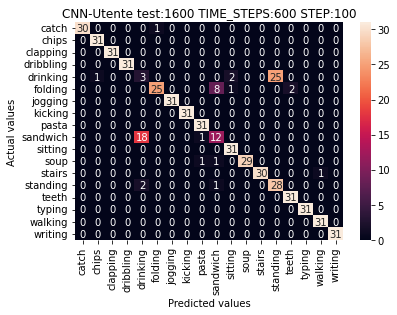

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.2342 - accuracy: 0.2231 - f1_m: 0.1351 - val_loss: 2.3514 - val_accuracy: 0.2402 - val_f1_m: 0.1556
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6605 - accuracy: 0.4104 - f1_m: 0.3117 - val_loss: 1.9479 - val_accuracy: 0.3587 - val_f1_m: 0.2542
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4201 - accuracy: 0.5069 - f1_m: 0.4457 - val_loss: 1.8698 - val_accuracy: 0.3998 - val_f1_m: 0.3654
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2489 - accuracy: 0.5723 - f1_m: 0.5381 - val_loss: 1.6141 - val_accuracy: 0.4906 - val_f1_m: 0.4242
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1113 - accuracy: 0.6183 - f1_m: 0.5958 - val_loss: 1.5708 - val_accuracy: 0.516

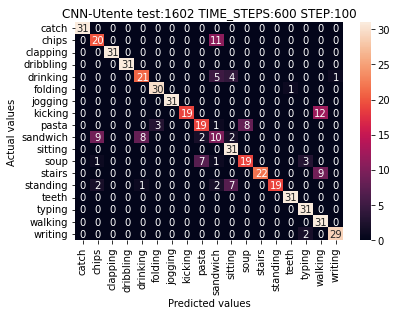

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3982 - accuracy: 0.1578 - f1_m: 0.0680 - val_loss: 2.4227 - val_accuracy: 0.1959 - val_f1_m: 0.0922
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.8165 - accuracy: 0.3289 - f1_m: 0.2045 - val_loss: 1.9157 - val_accuracy: 0.3415 - val_f1_m: 0.2634
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4783 - accuracy: 0.4583 - f1_m: 0.3754 - val_loss: 1.7232 - val_accuracy: 0.3965 - val_f1_m: 0.3466
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2927 - accuracy: 0.5229 - f1_m: 0.4698 - val_loss: 1.5588 - val_accuracy: 0.4583 - val_f1_m: 0.4177
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1488 - accuracy: 0.5729 - f1_m: 0.5269 - val_loss: 1.4404 - val_accuracy: 0.495

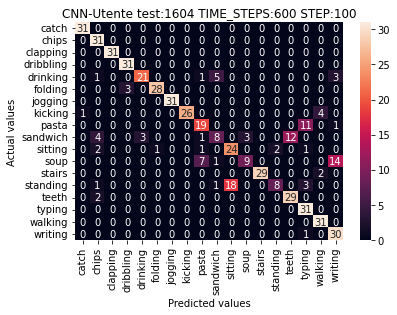

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3072 - accuracy: 0.1662 - f1_m: 0.1046 - val_loss: 1.9982 - val_accuracy: 0.2595 - val_f1_m: 0.1985
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.6940 - accuracy: 0.3706 - f1_m: 0.2754 - val_loss: 1.8002 - val_accuracy: 0.3525 - val_f1_m: 0.2877
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4468 - accuracy: 0.4638 - f1_m: 0.3915 - val_loss: 1.5031 - val_accuracy: 0.4925 - val_f1_m: 0.4567
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.2813 - accuracy: 0.5284 - f1_m: 0.4864 - val_loss: 1.4649 - val_accuracy: 0.5077 - val_f1_m: 0.4632
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1360 - accuracy: 0.5899 - f1_m: 0.5603 - val_loss: 1.2605 - val_accuracy: 0.574

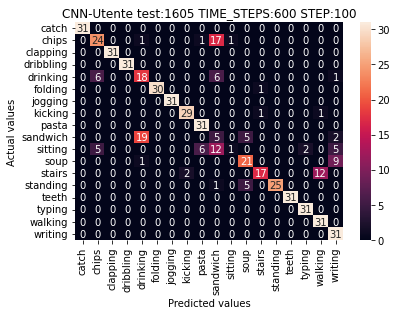

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 38ms/step - loss: 2.2503 - accuracy: 0.1968 - f1_m: 0.1318 - val_loss: 1.8469 - val_accuracy: 0.3479 - val_f1_m: 0.2273
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.5960 - accuracy: 0.4185 - f1_m: 0.3234 - val_loss: 1.7223 - val_accuracy: 0.3853 - val_f1_m: 0.3235
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3345 - accuracy: 0.5051 - f1_m: 0.4528 - val_loss: 1.4570 - val_accuracy: 0.5079 - val_f1_m: 0.4368
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1567 - accuracy: 0.5637 - f1_m: 0.5233 - val_loss: 1.2569 - val_accuracy: 0.5443 - val_f1_m: 0.5363
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0316 - accuracy: 0.6140 - f1_m: 0.5827 - val_loss: 1.2994 - val_accuracy: 0.551

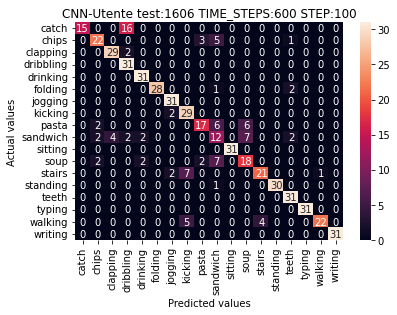

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3537 - accuracy: 0.1610 - f1_m: 0.0811 - val_loss: 2.3113 - val_accuracy: 0.2235 - val_f1_m: 0.0894
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.7873 - accuracy: 0.3333 - f1_m: 0.2072 - val_loss: 1.8141 - val_accuracy: 0.3617 - val_f1_m: 0.2659
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4390 - accuracy: 0.4669 - f1_m: 0.4000 - val_loss: 1.4430 - val_accuracy: 0.4969 - val_f1_m: 0.4214
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 1.1965 - accuracy: 0.5588 - f1_m: 0.5281 - val_loss: 1.3016 - val_accuracy: 0.5620 - val_f1_m: 0.5119
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 1.0466 - accuracy: 0.6145 - f1_m: 0.5911 - val_loss: 1.2383 - val_accuracy: 0.574

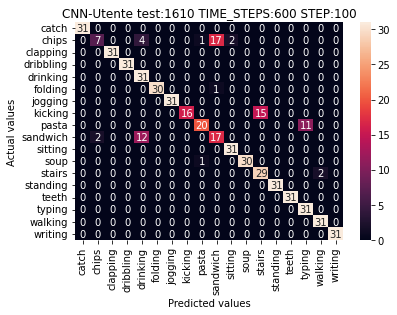

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2981 - accuracy: 0.1892 - f1_m: 0.1199 - val_loss: 2.2645 - val_accuracy: 0.2616 - val_f1_m: 0.1307
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.7248 - accuracy: 0.3667 - f1_m: 0.2683 - val_loss: 1.7520 - val_accuracy: 0.4124 - val_f1_m: 0.3270
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4493 - accuracy: 0.4741 - f1_m: 0.3915 - val_loss: 1.5987 - val_accuracy: 0.4807 - val_f1_m: 0.3483
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2416 - accuracy: 0.5596 - f1_m: 0.5081 - val_loss: 1.3150 - val_accuracy: 0.5711 - val_f1_m: 0.5550
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0386 - accuracy: 0.6360 - f1_m: 0.6187 - val_loss: 1.2763 - val_accuracy: 0.616

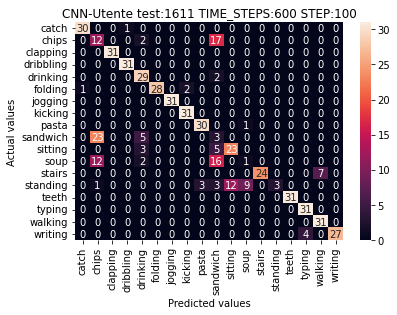

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3624 - accuracy: 0.1546 - f1_m: 0.0762 - val_loss: 2.0268 - val_accuracy: 0.2720 - val_f1_m: 0.0919
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.7225 - accuracy: 0.3747 - f1_m: 0.2571 - val_loss: 1.5854 - val_accuracy: 0.4341 - val_f1_m: 0.3351
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3330 - accuracy: 0.5227 - f1_m: 0.4631 - val_loss: 1.4536 - val_accuracy: 0.5068 - val_f1_m: 0.4345
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1076 - accuracy: 0.5903 - f1_m: 0.5587 - val_loss: 1.3579 - val_accuracy: 0.5581 - val_f1_m: 0.5556
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 0.9710 - accuracy: 0.6398 - f1_m: 0.6240 - val_loss: 1.0211 - val_accuracy: 0.650

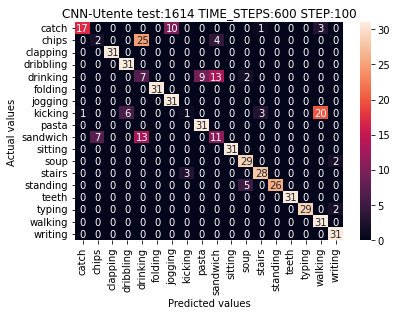

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2343 - accuracy: 0.2045 - f1_m: 0.1062 - val_loss: 1.8434 - val_accuracy: 0.3336 - val_f1_m: 0.2633
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6573 - accuracy: 0.3946 - f1_m: 0.2722 - val_loss: 1.4550 - val_accuracy: 0.4696 - val_f1_m: 0.3967
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3449 - accuracy: 0.5163 - f1_m: 0.4473 - val_loss: 1.5309 - val_accuracy: 0.4705 - val_f1_m: 0.4062
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1475 - accuracy: 0.5898 - f1_m: 0.5516 - val_loss: 1.3404 - val_accuracy: 0.5636 - val_f1_m: 0.5214
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0084 - accuracy: 0.6372 - f1_m: 0.6137 - val_loss: 1.1440 - val_accuracy: 0.597

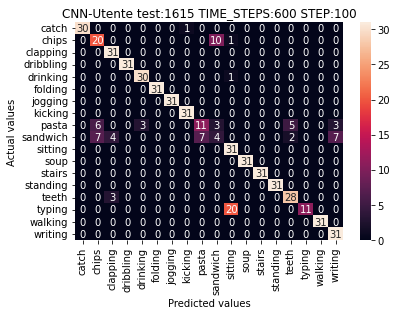

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.1686 - accuracy: 0.2336 - f1_m: 0.1680 - val_loss: 2.0509 - val_accuracy: 0.3094 - val_f1_m: 0.2494
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.5777 - accuracy: 0.4160 - f1_m: 0.3309 - val_loss: 2.1211 - val_accuracy: 0.3531 - val_f1_m: 0.2987
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3386 - accuracy: 0.5061 - f1_m: 0.4377 - val_loss: 1.9615 - val_accuracy: 0.4335 - val_f1_m: 0.3930
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1799 - accuracy: 0.5681 - f1_m: 0.5276 - val_loss: 1.7607 - val_accuracy: 0.4804 - val_f1_m: 0.4338
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0656 - accuracy: 0.6126 - f1_m: 0.5896 - val_loss: 1.6046 - val_accuracy: 0.540

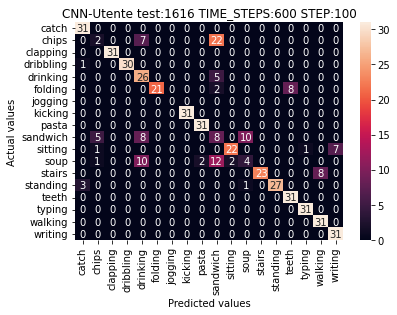

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.4202 - accuracy: 0.1436 - f1_m: 0.0567 - val_loss: 2.7809 - val_accuracy: 0.1302 - val_f1_m: 0.0521
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.8684 - accuracy: 0.3026 - f1_m: 0.1668 - val_loss: 2.2892 - val_accuracy: 0.2553 - val_f1_m: 0.1564
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5089 - accuracy: 0.4501 - f1_m: 0.3734 - val_loss: 1.9129 - val_accuracy: 0.3636 - val_f1_m: 0.3017
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2894 - accuracy: 0.5303 - f1_m: 0.4912 - val_loss: 1.6118 - val_accuracy: 0.4793 - val_f1_m: 0.4531
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.1483 - accuracy: 0.5895 - f1_m: 0.5551 - val_loss: 1.6931 - val_accuracy: 0.458

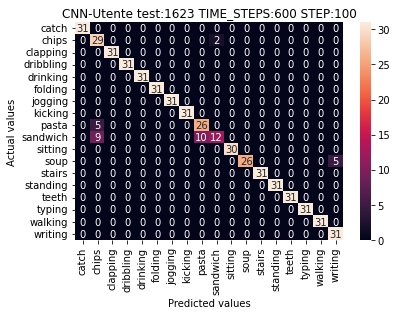

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.1935 - accuracy: 0.2206 - f1_m: 0.1230 - val_loss: 1.9972 - val_accuracy: 0.3261 - val_f1_m: 0.1758
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5908 - accuracy: 0.4038 - f1_m: 0.2968 - val_loss: 1.5518 - val_accuracy: 0.4675 - val_f1_m: 0.3089
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3078 - accuracy: 0.5086 - f1_m: 0.4424 - val_loss: 1.2715 - val_accuracy: 0.5569 - val_f1_m: 0.4849
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1454 - accuracy: 0.5777 - f1_m: 0.5359 - val_loss: 1.2469 - val_accuracy: 0.5663 - val_f1_m: 0.5384
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0284 - accuracy: 0.6218 - f1_m: 0.5946 - val_loss: 1.2824 - val_accuracy: 0.594

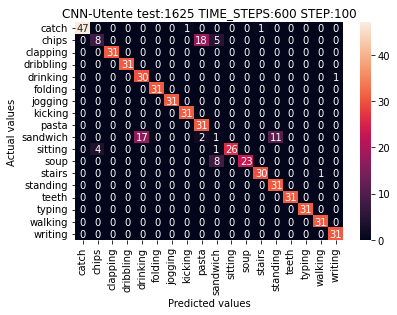

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.2779 - accuracy: 0.2009 - f1_m: 0.1408 - val_loss: 1.9962 - val_accuracy: 0.3065 - val_f1_m: 0.2613
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6443 - accuracy: 0.4041 - f1_m: 0.3009 - val_loss: 2.0194 - val_accuracy: 0.3663 - val_f1_m: 0.3029
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2945 - accuracy: 0.5352 - f1_m: 0.4840 - val_loss: 1.6106 - val_accuracy: 0.4860 - val_f1_m: 0.4253
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1219 - accuracy: 0.5934 - f1_m: 0.5550 - val_loss: 1.4907 - val_accuracy: 0.5411 - val_f1_m: 0.4729
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0066 - accuracy: 0.6359 - f1_m: 0.6116 - val_loss: 1.3093 - val_accuracy: 0.595

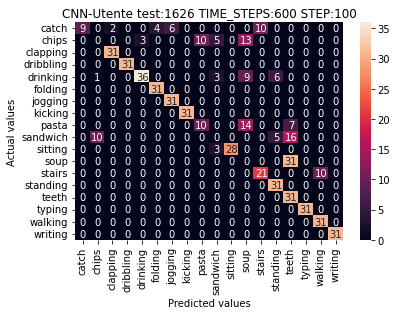

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3677 - accuracy: 0.1516 - f1_m: 0.0754 - val_loss: 2.5261 - val_accuracy: 0.1633 - val_f1_m: 0.0557
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.8398 - accuracy: 0.3237 - f1_m: 0.1960 - val_loss: 2.7180 - val_accuracy: 0.2800 - val_f1_m: 0.2593
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4790 - accuracy: 0.4606 - f1_m: 0.3997 - val_loss: 1.7458 - val_accuracy: 0.4436 - val_f1_m: 0.3739
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2705 - accuracy: 0.5390 - f1_m: 0.4984 - val_loss: 1.8507 - val_accuracy: 0.4325 - val_f1_m: 0.3993
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1114 - accuracy: 0.5947 - f1_m: 0.5686 - val_loss: 1.6558 - val_accuracy: 0.506

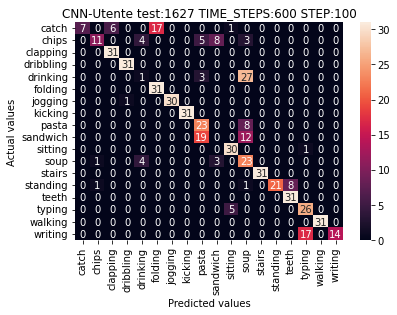

Utente test:  1630
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3320 - accuracy: 0.1609 - f1_m: 0.0872 - val_loss: 2.1675 - val_accuracy: 0.2641 - val_f1_m: 0.0396
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.7722 - accuracy: 0.3499 - f1_m: 0.2244 - val_loss: 1.8353 - val_accuracy: 0.3666 - val_f1_m: 0.2316
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3921 - accuracy: 0.5000 - f1_m: 0.4325 - val_loss: 1.7636 - val_accuracy: 0.4091 - val_f1_m: 0.3353
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1701 - accuracy: 0.5724 - f1_m: 0.5332 - val_loss: 1.7546 - val_accuracy: 0.5009 - val_f1_m: 0.4848
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0460 - accuracy: 0.6146 - f1_m: 0.5868 - val_loss: 1.2365 - val_accuracy: 0.596

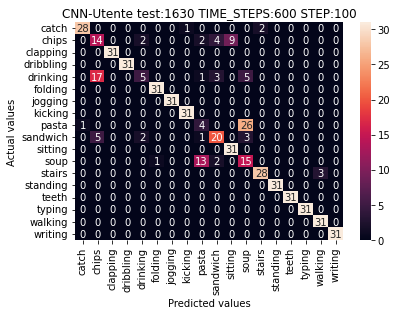

Utente test:  1631
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2372 - accuracy: 0.1978 - f1_m: 0.1005 - val_loss: 2.1279 - val_accuracy: 0.2764 - val_f1_m: 0.1464
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.7289 - accuracy: 0.3537 - f1_m: 0.2566 - val_loss: 1.8250 - val_accuracy: 0.3676 - val_f1_m: 0.3342
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4187 - accuracy: 0.4820 - f1_m: 0.4003 - val_loss: 1.6722 - val_accuracy: 0.4864 - val_f1_m: 0.4068
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.2043 - accuracy: 0.5630 - f1_m: 0.5235 - val_loss: 1.5241 - val_accuracy: 0.5315 - val_f1_m: 0.4939
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0433 - accuracy: 0.6219 - f1_m: 0.5997 - val_loss: 1.3023 - val_accuracy: 0.571

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


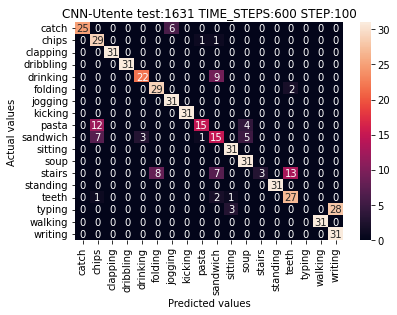

Utente test:  1632
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3016 - accuracy: 0.1797 - f1_m: 0.0892 - val_loss: 2.4998 - val_accuracy: 0.2701 - val_f1_m: 0.1132
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6494 - accuracy: 0.4101 - f1_m: 0.3175 - val_loss: 1.8766 - val_accuracy: 0.4023 - val_f1_m: 0.3290
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2845 - accuracy: 0.5496 - f1_m: 0.5056 - val_loss: 1.6082 - val_accuracy: 0.4977 - val_f1_m: 0.4750
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0956 - accuracy: 0.6057 - f1_m: 0.5834 - val_loss: 1.2624 - val_accuracy: 0.5538 - val_f1_m: 0.5482
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9492 - accuracy: 0.6517 - f1_m: 0.6394 - val_loss: 1.1235 - val_accuracy: 0.612

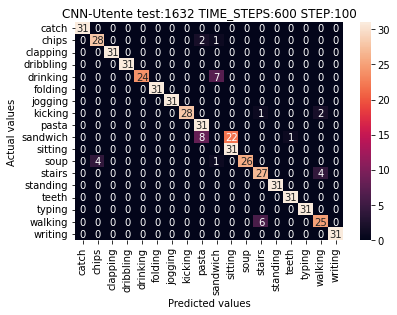

Utente test:  1634
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3061 - accuracy: 0.2066 - f1_m: 0.1161 - val_loss: 2.3619 - val_accuracy: 0.2649 - val_f1_m: 0.2225
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.6020 - accuracy: 0.4342 - f1_m: 0.3379 - val_loss: 1.7224 - val_accuracy: 0.4422 - val_f1_m: 0.3436
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3026 - accuracy: 0.5457 - f1_m: 0.4789 - val_loss: 1.5204 - val_accuracy: 0.5197 - val_f1_m: 0.4914
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0711 - accuracy: 0.6266 - f1_m: 0.6020 - val_loss: 1.4542 - val_accuracy: 0.5752 - val_f1_m: 0.5572
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9346 - accuracy: 0.6725 - f1_m: 0.6573 - val_loss: 1.2997 - val_accuracy: 0.612

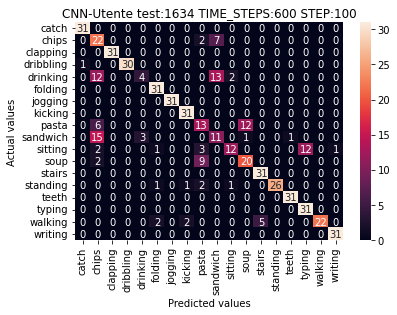

Utente test:  1635
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.1936 - accuracy: 0.2224 - f1_m: 0.1394 - val_loss: 1.9864 - val_accuracy: 0.3363 - val_f1_m: 0.2440
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6245 - accuracy: 0.4023 - f1_m: 0.3278 - val_loss: 1.6063 - val_accuracy: 0.4219 - val_f1_m: 0.3975
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.3799 - accuracy: 0.5033 - f1_m: 0.4572 - val_loss: 1.3442 - val_accuracy: 0.5405 - val_f1_m: 0.5142
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1726 - accuracy: 0.5775 - f1_m: 0.5576 - val_loss: 1.3101 - val_accuracy: 0.5689 - val_f1_m: 0.5554
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0428 - accuracy: 0.6194 - f1_m: 0.6027 - val_loss: 1.2100 - val_accuracy: 0.610

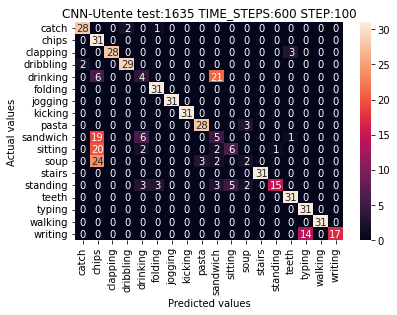

Utente test:  1641
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 10s 45ms/step - loss: 2.2894 - accuracy: 0.1863 - f1_m: 0.1040 - val_loss: 1.9826 - val_accuracy: 0.3130 - val_f1_m: 0.1752
Epoch 2/100
199/199 [==============================] - 8s 39ms/step - loss: 1.6102 - accuracy: 0.3987 - f1_m: 0.3115 - val_loss: 1.6764 - val_accuracy: 0.4232 - val_f1_m: 0.2978
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3387 - accuracy: 0.5120 - f1_m: 0.4550 - val_loss: 1.4905 - val_accuracy: 0.4876 - val_f1_m: 0.4376
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1266 - accuracy: 0.5829 - f1_m: 0.5582 - val_loss: 1.2842 - val_accuracy: 0.5834 - val_f1_m: 0.5345
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9669 - accuracy: 0.6422 - f1_m: 0.6256 - val_loss: 1.1029 - val_accuracy: 0.62

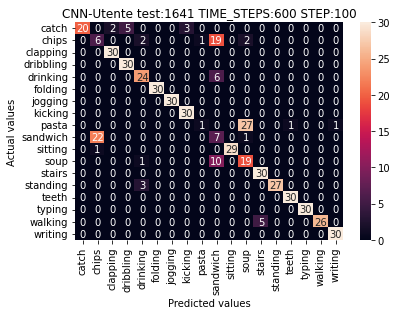

Utente test:  1643
Training: x-> 25454 y-> 25454
Validation: x-> 6364 y-> 6364
Testing: x-> 542 y-> 542
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.2806 - accuracy: 0.2013 - f1_m: 0.1021 - val_loss: 1.9825 - val_accuracy: 0.2993 - val_f1_m: 0.2186
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5822 - accuracy: 0.4290 - f1_m: 0.3219 - val_loss: 1.8443 - val_accuracy: 0.4145 - val_f1_m: 0.3055
Epoch 3/100
199/199 [==============================] - 8s 39ms/step - loss: 1.3073 - accuracy: 0.5267 - f1_m: 0.4763 - val_loss: 1.4398 - val_accuracy: 0.4980 - val_f1_m: 0.4443
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1464 - accuracy: 0.5867 - f1_m: 0.5555 - val_loss: 1.2519 - val_accuracy: 0.5622 - val_f1_m: 0.5335
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0059 - accuracy: 0.6439 - f1_m: 0.6367 - val_loss: 1.2257 - val_accuracy: 0.601

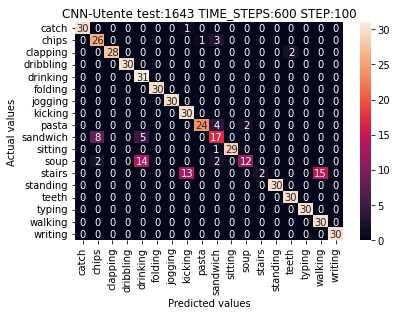

Utente test:  1645
Training: x-> 25430 y-> 25430
Validation: x-> 6358 y-> 6358
Testing: x-> 572 y-> 572
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.3339 - accuracy: 0.1673 - f1_m: 0.0880 - val_loss: 2.0126 - val_accuracy: 0.2708 - val_f1_m: 0.1209
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6754 - accuracy: 0.3812 - f1_m: 0.2901 - val_loss: 1.7421 - val_accuracy: 0.3984 - val_f1_m: 0.3042
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.4412 - accuracy: 0.4672 - f1_m: 0.4235 - val_loss: 1.9140 - val_accuracy: 0.3938 - val_f1_m: 0.3333
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3253 - accuracy: 0.5041 - f1_m: 0.4769 - val_loss: 1.5899 - val_accuracy: 0.4794 - val_f1_m: 0.4079
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2077 - accuracy: 0.5653 - f1_m: 0.5233 - val_loss: 1.3549 - val_accuracy: 0.553

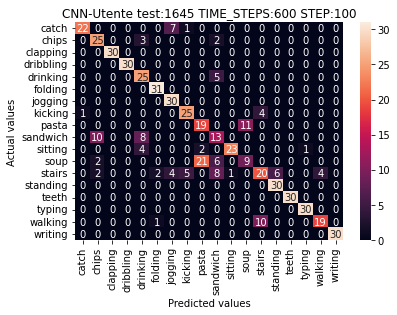

Utente test:  1646
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.2666 - accuracy: 0.1938 - f1_m: 0.0972 - val_loss: 1.9968 - val_accuracy: 0.2998 - val_f1_m: 0.1521
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6559 - accuracy: 0.3890 - f1_m: 0.2808 - val_loss: 1.8191 - val_accuracy: 0.3738 - val_f1_m: 0.2412
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4239 - accuracy: 0.4835 - f1_m: 0.4045 - val_loss: 1.4957 - val_accuracy: 0.4690 - val_f1_m: 0.3738
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2395 - accuracy: 0.5581 - f1_m: 0.5056 - val_loss: 1.3919 - val_accuracy: 0.5233 - val_f1_m: 0.4960
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0685 - accuracy: 0.6168 - f1_m: 0.5976 - val_loss: 1.0928 - val_accuracy: 0.619

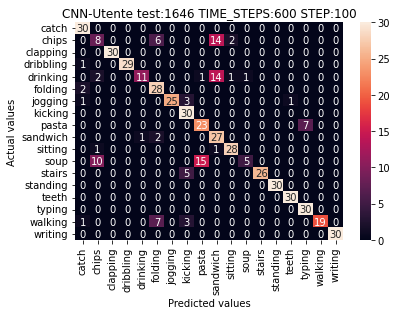

Utente test:  1647
Training: x-> 25436 y-> 25436
Validation: x-> 6360 y-> 6360
Testing: x-> 564 y-> 564
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.4754 - accuracy: 0.1526 - f1_m: 0.0518 - val_loss: 2.1000 - val_accuracy: 0.2648 - val_f1_m: 0.1280
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.7078 - accuracy: 0.3738 - f1_m: 0.2562 - val_loss: 1.6648 - val_accuracy: 0.4277 - val_f1_m: 0.3079
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3700 - accuracy: 0.4982 - f1_m: 0.4293 - val_loss: 1.8231 - val_accuracy: 0.4426 - val_f1_m: 0.3797
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1513 - accuracy: 0.5748 - f1_m: 0.5284 - val_loss: 1.6014 - val_accuracy: 0.4879 - val_f1_m: 0.4644
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0142 - accuracy: 0.6245 - f1_m: 0.5982 - val_loss: 1.1479 - val_accuracy: 0.603

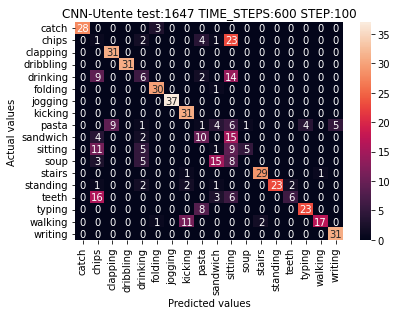

Utente test:  1649
Training: x-> 25440 y-> 25440
Validation: x-> 6360 y-> 6360
Testing: x-> 560 y-> 560
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.2526 - accuracy: 0.1935 - f1_m: 0.1214 - val_loss: 2.0906 - val_accuracy: 0.2931 - val_f1_m: 0.2126
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6661 - accuracy: 0.3743 - f1_m: 0.2715 - val_loss: 1.9688 - val_accuracy: 0.3421 - val_f1_m: 0.2985
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4716 - accuracy: 0.4530 - f1_m: 0.3831 - val_loss: 1.7370 - val_accuracy: 0.4332 - val_f1_m: 0.3829
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2914 - accuracy: 0.5320 - f1_m: 0.4683 - val_loss: 1.6633 - val_accuracy: 0.4931 - val_f1_m: 0.4699
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1210 - accuracy: 0.5965 - f1_m: 0.5602 - val_loss: 1.4327 - val_accuracy: 0.564

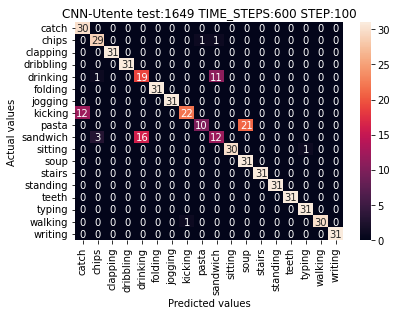

Accuracy media: 0.8061367306015087
F1 weighted media: 0.7922405319485408
F1 macro media: 0.7927194277410301
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.806137             0.792241          0.792719   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              model = createCNN(X_train[0].shape, y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              cnn_acc.append(accuracy_score(rounded_labels, y_pred))
              cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              cnn_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

              cnn_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


# Bi-LSTM

In [ ]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [ ]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [ ]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1600
Epoch 1/100
50/50 [==============================] - 26s 250ms/step - loss: 2.6578 - accuracy: 0.1565 - val_loss: 2.3746 - val_accuracy: 0.2522
Epoch 2/100
50/50 [==============================] - 11s 224ms/step - loss: 2.4129 - accuracy: 0.2289 - val_loss: 2.1986 - val_accuracy: 0.2980
Epoch 3/100
50/50 [==============================] - 11s 227ms/step - loss: 2.2882 - accuracy: 0.2666 - val_loss: 2.1065 - val_accuracy: 0.3008
Epoch 4/100
50/50 [==============================] - 11s 228ms/step - loss: 2.1650 - accuracy: 0.2902 - val_loss: 1.9912 - val_accuracy: 0.3349
Epoch 5/100
50/50 [==============================] - 11s 223ms/step - loss: 2.0785 - accuracy: 0.3067 - val_loss: 1.8674 - val_accuracy: 0.3712
Epoch 6/100
50/50 [==============================] - 11s 226ms/step - loss: 1.9585 - accuracy: 0.3437 - val_loss: 1.8559 - val_accuracy: 0.3731
Epoch 7/100
50/50 [==============================] - 12s 236ms/step - loss: 1.9653 - accuracy: 0.3421 - val_l

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    0.4194    0.5909        31
           1     0.4634    0.6129    0.5278        31
           2     0.0000    0.0000    0.0000        31
           3     0.6596    1.0000    0.7949        31
           4     0.0000    0.0000    0.0000        31
           5     0.8000    0.5556    0.6557        36
           6     1.0000    1.0000    1.0000        31
           7     0.2778    0.3226    0.2985        31
           8     0.3333    0.5806    0.4235        31
           9     0.0000    0.0000    0.0000        31
          10     1.0000    1.0000    1.0000        31
          11     0.2188    0.2258    0.2222        31
          12     0.0000    0.0000    0.0000        31
          13     0.4483    0.8387    0.5843        31
          14     0.2605    1.0000    0.4133        31
          15     1.0000    1.0000    1.0000        31
          16     0.1538    0.1290    0.1404        31
          17     1.0000    

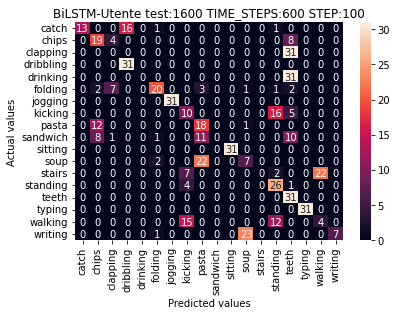

Utente test:  1602
Epoch 1/100
50/50 [==============================] - 22s 271ms/step - loss: 2.6454 - accuracy: 0.1529 - val_loss: 2.3956 - val_accuracy: 0.2179
Epoch 2/100
50/50 [==============================] - 11s 230ms/step - loss: 2.3737 - accuracy: 0.2369 - val_loss: 2.1063 - val_accuracy: 0.3124
Epoch 3/100
50/50 [==============================] - 12s 234ms/step - loss: 2.1685 - accuracy: 0.2812 - val_loss: 1.9756 - val_accuracy: 0.3457
Epoch 4/100
50/50 [==============================] - 12s 234ms/step - loss: 2.1635 - accuracy: 0.2838 - val_loss: 2.0629 - val_accuracy: 0.3160
Epoch 5/100
50/50 [==============================] - 12s 238ms/step - loss: 2.0589 - accuracy: 0.3019 - val_loss: 1.8590 - val_accuracy: 0.3679
Epoch 6/100
50/50 [==============================] - 12s 236ms/step - loss: 2.0048 - accuracy: 0.3177 - val_loss: 1.8270 - val_accuracy: 0.3933
Epoch 7/100
50/50 [==============================] - 11s 229ms/step - loss: 1.9280 - accuracy: 0.3502 - val_loss: 1.8

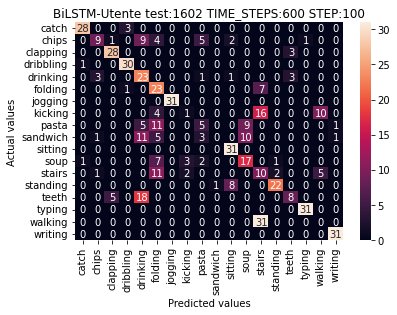

Utente test:  1604
Epoch 1/100
50/50 [==============================] - 21s 260ms/step - loss: 2.6666 - accuracy: 0.1587 - val_loss: 2.3256 - val_accuracy: 0.2770
Epoch 2/100
50/50 [==============================] - 12s 237ms/step - loss: 2.3540 - accuracy: 0.2439 - val_loss: 2.0901 - val_accuracy: 0.3289
Epoch 3/100
50/50 [==============================] - 11s 230ms/step - loss: 2.2135 - accuracy: 0.2797 - val_loss: 2.0474 - val_accuracy: 0.3314
Epoch 4/100
50/50 [==============================] - 11s 229ms/step - loss: 2.1422 - accuracy: 0.2913 - val_loss: 1.9190 - val_accuracy: 0.3669
Epoch 5/100
50/50 [==============================] - 12s 235ms/step - loss: 2.0581 - accuracy: 0.3172 - val_loss: 1.8481 - val_accuracy: 0.3764
Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 2.0201 - accuracy: 0.3279 - val_loss: 1.8270 - val_accuracy: 0.3896
Epoch 7/100
50/50 [==============================] - 11s 229ms/step - loss: 2.0410 - accuracy: 0.3239 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


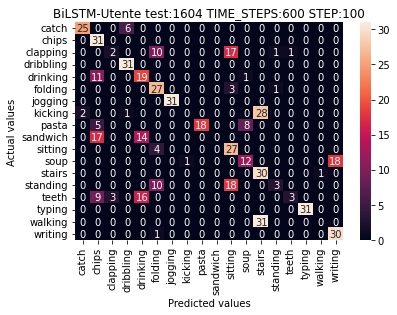

Utente test:  1605
Epoch 1/100
50/50 [==============================] - 20s 249ms/step - loss: 2.6494 - accuracy: 0.1576 - val_loss: 2.3478 - val_accuracy: 0.2608
Epoch 2/100
50/50 [==============================] - 11s 223ms/step - loss: 2.3648 - accuracy: 0.2428 - val_loss: 2.1071 - val_accuracy: 0.3098
Epoch 3/100
50/50 [==============================] - 11s 223ms/step - loss: 2.2507 - accuracy: 0.2715 - val_loss: 2.1133 - val_accuracy: 0.3127
Epoch 4/100
50/50 [==============================] - 11s 224ms/step - loss: 2.1707 - accuracy: 0.2876 - val_loss: 1.9422 - val_accuracy: 0.3528
Epoch 5/100
50/50 [==============================] - 11s 225ms/step - loss: 2.0949 - accuracy: 0.3027 - val_loss: 1.8855 - val_accuracy: 0.3643
Epoch 6/100
50/50 [==============================] - 12s 233ms/step - loss: 2.0999 - accuracy: 0.3086 - val_loss: 2.4221 - val_accuracy: 0.2282
Epoch 7/100
50/50 [==============================] - 11s 227ms/step - loss: 2.3537 - accuracy: 0.2450 - val_loss: 2.1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5000    0.0645    0.1143        31
           1     0.6889    0.7045    0.6966        44
           2     0.6667    0.1290    0.2162        31
           3     0.7949    1.0000    0.8857        31
           4     0.6316    0.3871    0.4800        31
           5     0.6786    0.6129    0.6441        31
           6     0.4912    0.9032    0.6364        31
           7     0.6667    0.0645    0.1176        31
           8     0.5854    0.7742    0.6667        31
           9     0.0000    0.0000    0.0000        31
          10     0.0000    0.0000    0.0000        31
          11     0.5345    1.0000    0.6966        31
          12     0.1000    0.0968    0.0984        31
          13     0.7000    0.2258    0.3415        31
          14     0.4839    0.9677    0.6452        31
          15     0.5636    1.0000    0.7209        31
          16     0.4079    1.0000    0.5794        31
          17     0.8378    

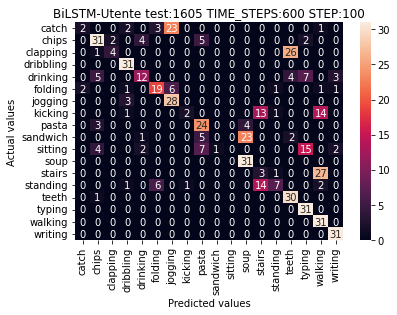

Utente test:  1606
Epoch 1/100
50/50 [==============================] - 21s 255ms/step - loss: 2.6595 - accuracy: 0.1603 - val_loss: 2.3176 - val_accuracy: 0.2509
Epoch 2/100
50/50 [==============================] - 11s 229ms/step - loss: 2.3357 - accuracy: 0.2529 - val_loss: 2.1260 - val_accuracy: 0.3246
Epoch 3/100
50/50 [==============================] - 11s 223ms/step - loss: 2.2696 - accuracy: 0.2713 - val_loss: 2.1978 - val_accuracy: 0.2839
Epoch 4/100
50/50 [==============================] - 12s 231ms/step - loss: 2.1714 - accuracy: 0.2878 - val_loss: 1.9545 - val_accuracy: 0.3336
Epoch 5/100
50/50 [==============================] - 12s 231ms/step - loss: 2.0790 - accuracy: 0.3070 - val_loss: 1.9305 - val_accuracy: 0.3399
Epoch 6/100
50/50 [==============================] - 11s 225ms/step - loss: 2.0074 - accuracy: 0.3219 - val_loss: 1.8086 - val_accuracy: 0.3790
Epoch 7/100
50/50 [==============================] - 11s 225ms/step - loss: 2.1271 - accuracy: 0.3001 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


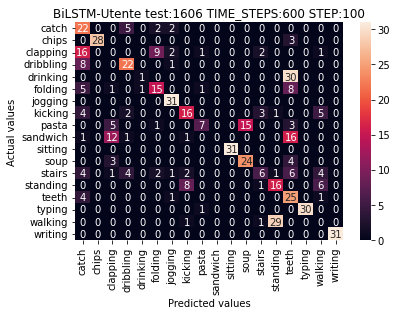

Utente test:  1610
Epoch 1/100
50/50 [==============================] - 20s 255ms/step - loss: 2.6703 - accuracy: 0.1459 - val_loss: 2.3935 - val_accuracy: 0.2553
Epoch 2/100
50/50 [==============================] - 11s 230ms/step - loss: 2.3917 - accuracy: 0.2345 - val_loss: 2.1822 - val_accuracy: 0.2878
Epoch 3/100
50/50 [==============================] - 11s 230ms/step - loss: 2.2071 - accuracy: 0.2729 - val_loss: 1.9988 - val_accuracy: 0.3127
Epoch 4/100
50/50 [==============================] - 11s 224ms/step - loss: 2.0538 - accuracy: 0.3130 - val_loss: 1.9055 - val_accuracy: 0.3600
Epoch 5/100
50/50 [==============================] - 11s 225ms/step - loss: 2.1305 - accuracy: 0.2959 - val_loss: 2.0748 - val_accuracy: 0.3177
Epoch 6/100
50/50 [==============================] - 11s 226ms/step - loss: 2.0747 - accuracy: 0.3055 - val_loss: 1.9377 - val_accuracy: 0.3595
Epoch 7/100
50/50 [==============================] - 12s 233ms/step - loss: 2.0749 - accuracy: 0.3091 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


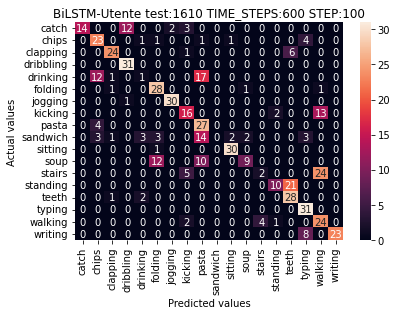

Utente test:  1611
Epoch 1/100
50/50 [==============================] - 22s 270ms/step - loss: 2.6438 - accuracy: 0.1706 - val_loss: 2.3139 - val_accuracy: 0.2784
Epoch 2/100
50/50 [==============================] - 11s 226ms/step - loss: 2.3554 - accuracy: 0.2432 - val_loss: 2.1002 - val_accuracy: 0.3283
Epoch 3/100
50/50 [==============================] - 11s 226ms/step - loss: 2.1885 - accuracy: 0.2819 - val_loss: 1.9328 - val_accuracy: 0.3641
Epoch 4/100
50/50 [==============================] - 12s 235ms/step - loss: 2.0301 - accuracy: 0.3262 - val_loss: 1.8242 - val_accuracy: 0.4048
Epoch 5/100
50/50 [==============================] - 12s 234ms/step - loss: 1.9801 - accuracy: 0.3409 - val_loss: 1.8264 - val_accuracy: 0.4064
Epoch 6/100
50/50 [==============================] - 12s 236ms/step - loss: 1.9115 - accuracy: 0.3676 - val_loss: 1.8118 - val_accuracy: 0.4014
Epoch 7/100
50/50 [==============================] - 11s 230ms/step - loss: 1.9739 - accuracy: 0.3442 - val_loss: 1.7

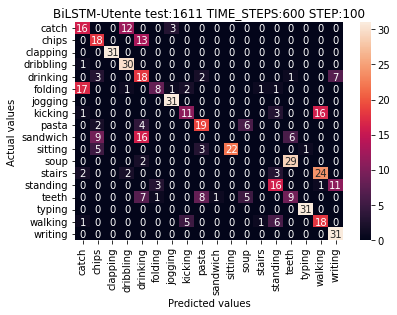

Utente test:  1614
Epoch 1/100
50/50 [==============================] - 22s 265ms/step - loss: 2.6615 - accuracy: 0.1527 - val_loss: 2.3202 - val_accuracy: 0.2526
Epoch 2/100
50/50 [==============================] - 11s 229ms/step - loss: 2.3289 - accuracy: 0.2492 - val_loss: 2.0947 - val_accuracy: 0.3059
Epoch 3/100
50/50 [==============================] - 11s 230ms/step - loss: 2.1789 - accuracy: 0.2886 - val_loss: 1.9586 - val_accuracy: 0.3424
Epoch 4/100
50/50 [==============================] - 11s 223ms/step - loss: 2.0625 - accuracy: 0.3175 - val_loss: 1.8677 - val_accuracy: 0.3704
Epoch 5/100
50/50 [==============================] - 11s 224ms/step - loss: 2.1046 - accuracy: 0.3085 - val_loss: 1.9689 - val_accuracy: 0.3477
Epoch 6/100
50/50 [==============================] - 12s 232ms/step - loss: 2.0808 - accuracy: 0.3115 - val_loss: 1.8497 - val_accuracy: 0.3795
Epoch 7/100
50/50 [==============================] - 12s 233ms/step - loss: 1.9873 - accuracy: 0.3340 - val_loss: 1.7

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


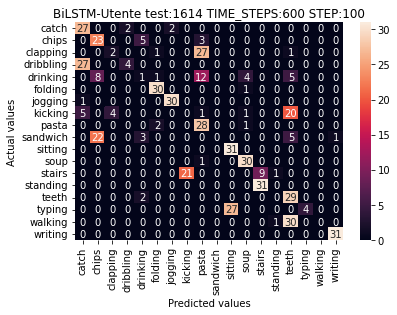

Utente test:  1615
Epoch 1/100
50/50 [==============================] - 21s 266ms/step - loss: 2.6492 - accuracy: 0.1505 - val_loss: 2.3517 - val_accuracy: 0.2482
Epoch 2/100
50/50 [==============================] - 12s 243ms/step - loss: 2.3750 - accuracy: 0.2290 - val_loss: 2.1193 - val_accuracy: 0.3242
Epoch 3/100
50/50 [==============================] - 12s 236ms/step - loss: 2.2022 - accuracy: 0.2772 - val_loss: 1.9621 - val_accuracy: 0.3504
Epoch 4/100
50/50 [==============================] - 12s 239ms/step - loss: 2.1373 - accuracy: 0.2906 - val_loss: 1.9729 - val_accuracy: 0.3455
Epoch 5/100
50/50 [==============================] - 12s 231ms/step - loss: 2.1043 - accuracy: 0.3001 - val_loss: 1.8742 - val_accuracy: 0.3765
Epoch 6/100
50/50 [==============================] - 11s 230ms/step - loss: 2.0041 - accuracy: 0.3292 - val_loss: 1.9459 - val_accuracy: 0.3595
Epoch 7/100
50/50 [==============================] - 12s 237ms/step - loss: 2.0685 - accuracy: 0.3169 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


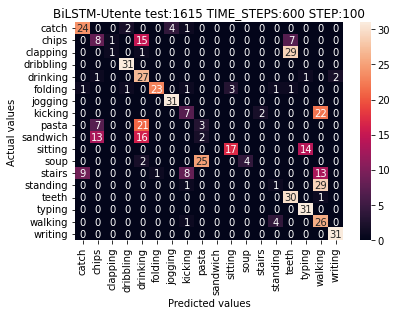

Utente test:  1616
Epoch 1/100
50/50 [==============================] - 20s 256ms/step - loss: 2.6482 - accuracy: 0.1518 - val_loss: 2.4514 - val_accuracy: 0.2114
Epoch 2/100
50/50 [==============================] - 12s 232ms/step - loss: 2.3998 - accuracy: 0.2360 - val_loss: 2.2636 - val_accuracy: 0.2668
Epoch 3/100
50/50 [==============================] - 12s 236ms/step - loss: 2.2744 - accuracy: 0.2573 - val_loss: 2.0478 - val_accuracy: 0.3253
Epoch 4/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1279 - accuracy: 0.2926 - val_loss: 1.9731 - val_accuracy: 0.3454
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 2.0248 - accuracy: 0.3155 - val_loss: 1.8400 - val_accuracy: 0.3622
Epoch 6/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1441 - accuracy: 0.2997 - val_loss: 1.9566 - val_accuracy: 0.3484
Epoch 7/100
50/50 [==============================] - 12s 231ms/step - loss: 2.0456 - accuracy: 0.3120 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


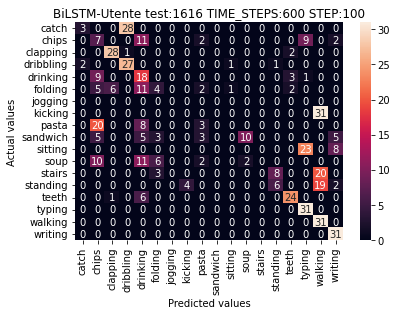

Utente test:  1623
Epoch 1/100
50/50 [==============================] - 22s 275ms/step - loss: 2.6568 - accuracy: 0.1635 - val_loss: 2.3731 - val_accuracy: 0.2522
Epoch 2/100
50/50 [==============================] - 12s 234ms/step - loss: 2.3532 - accuracy: 0.2508 - val_loss: 2.0904 - val_accuracy: 0.3157
Epoch 3/100
50/50 [==============================] - 12s 243ms/step - loss: 2.1904 - accuracy: 0.2872 - val_loss: 1.9526 - val_accuracy: 0.3400
Epoch 4/100
50/50 [==============================] - 12s 241ms/step - loss: 2.1185 - accuracy: 0.3043 - val_loss: 1.9276 - val_accuracy: 0.3598
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 2.0552 - accuracy: 0.3248 - val_loss: 1.8657 - val_accuracy: 0.3812
Epoch 6/100
50/50 [==============================] - 12s 231ms/step - loss: 2.0184 - accuracy: 0.3323 - val_loss: 1.9688 - val_accuracy: 0.3562
Epoch 7/100
50/50 [==============================] - 12s 230ms/step - loss: 1.9847 - accuracy: 0.3432 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.8824    0.9677    0.9231        31
           1     0.7500    0.1935    0.3077        31
           2     0.3214    0.2903    0.3051        31
           3     0.9688    1.0000    0.9841        31
           4     0.4318    0.6129    0.5067        31
           5     0.7500    0.7742    0.7619        31
           6     0.9394    1.0000    0.9688        31
           7     0.2105    0.1290    0.1600        31
           8     0.2353    0.3871    0.2927        31
           9     0.0000    0.0000    0.0000        31
          10     1.0000    1.0000    1.0000        30
          11     0.5800    0.9355    0.7160        31
          12     0.0000    0.0000    0.0000        31
          13     0.6875    0.7097    0.6984        31
          14     0.4167    0.3226    0.3636        31
          15     1.0000    1.0000    1.0000        31
          16     0.4189    1.0000    0.5905        31
          17     0.9394    

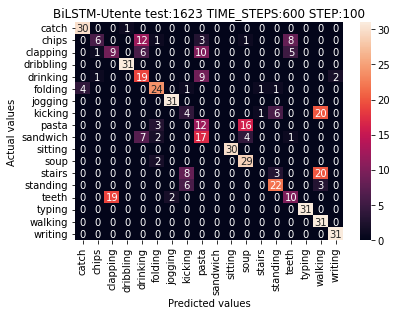

Utente test:  1625
Epoch 1/100
50/50 [==============================] - 21s 263ms/step - loss: 2.6768 - accuracy: 0.1496 - val_loss: 2.3698 - val_accuracy: 0.2490
Epoch 2/100
50/50 [==============================] - 12s 233ms/step - loss: 2.3423 - accuracy: 0.2488 - val_loss: 2.0635 - val_accuracy: 0.3206
Epoch 3/100
50/50 [==============================] - 12s 235ms/step - loss: 2.1550 - accuracy: 0.2907 - val_loss: 1.9055 - val_accuracy: 0.3601
Epoch 4/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1106 - accuracy: 0.3018 - val_loss: 1.9023 - val_accuracy: 0.3565
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 1.9917 - accuracy: 0.3289 - val_loss: 1.8396 - val_accuracy: 0.3900
Epoch 6/100
50/50 [==============================] - 12s 232ms/step - loss: 2.1353 - accuracy: 0.3016 - val_loss: 1.9605 - val_accuracy: 0.3511
Epoch 7/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1017 - accuracy: 0.3003 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


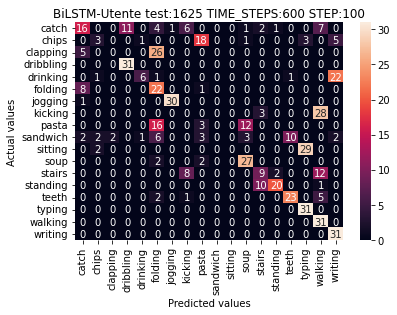

Utente test:  1627
Epoch 1/100
50/50 [==============================] - 21s 257ms/step - loss: 2.6515 - accuracy: 0.1601 - val_loss: 2.3702 - val_accuracy: 0.2441
Epoch 2/100
50/50 [==============================] - 12s 233ms/step - loss: 2.3789 - accuracy: 0.2438 - val_loss: 2.1476 - val_accuracy: 0.3091
Epoch 3/100
50/50 [==============================] - 12s 236ms/step - loss: 2.2206 - accuracy: 0.2769 - val_loss: 2.0383 - val_accuracy: 0.3284
Epoch 4/100
50/50 [==============================] - 12s 235ms/step - loss: 2.0719 - accuracy: 0.3097 - val_loss: 1.9255 - val_accuracy: 0.3724
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 1.9995 - accuracy: 0.3286 - val_loss: 1.8346 - val_accuracy: 0.3938
Epoch 6/100
50/50 [==============================] - 12s 231ms/step - loss: 1.9675 - accuracy: 0.3450 - val_loss: 1.8705 - val_accuracy: 0.3737
Epoch 7/100
50/50 [==============================] - 12s 231ms/step - loss: 2.0379 - accuracy: 0.3193 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


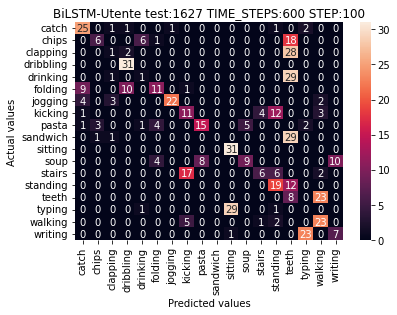

Utente test:  1630
Epoch 1/100
50/50 [==============================] - 21s 265ms/step - loss: 2.6669 - accuracy: 0.1569 - val_loss: 2.3418 - val_accuracy: 0.2600
Epoch 2/100
50/50 [==============================] - 12s 235ms/step - loss: 2.3818 - accuracy: 0.2426 - val_loss: 2.1411 - val_accuracy: 0.2990
Epoch 3/100
50/50 [==============================] - 12s 243ms/step - loss: 2.2016 - accuracy: 0.2785 - val_loss: 1.9768 - val_accuracy: 0.3435
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.1215 - accuracy: 0.2987 - val_loss: 1.9811 - val_accuracy: 0.3309
Epoch 5/100
50/50 [==============================] - 12s 233ms/step - loss: 2.0598 - accuracy: 0.3140 - val_loss: 1.8839 - val_accuracy: 0.3705
Epoch 6/100
50/50 [==============================] - 11s 230ms/step - loss: 2.0298 - accuracy: 0.3284 - val_loss: 1.8716 - val_accuracy: 0.3762
Epoch 7/100
50/50 [==============================] - 12s 238ms/step - loss: 2.0490 - accuracy: 0.3263 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6316    0.3871    0.4800        31
           1     0.4545    0.3226    0.3774        31
           2     0.6667    0.1290    0.2162        31
           3     0.8889    0.7742    0.8276        31
           4     0.6667    0.0645    0.1176        31
           5     0.8095    0.5484    0.6538        31
           6     1.0000    1.0000    1.0000        31
           7     0.0000    0.0000    0.0000        31
           8     0.4138    0.3871    0.4000        31
           9     0.0000    0.0000    0.0000        31
          10     0.5000    0.1290    0.2051        31
          11     0.5135    0.6129    0.5588        31
          12     0.2222    0.1290    0.1633        31
          13     0.1818    0.0645    0.0952        31
          14     0.2168    1.0000    0.3563        31
          15     0.8611    1.0000    0.9254        31
          16     0.2432    0.8710    0.3803        31
          17     1.0000    

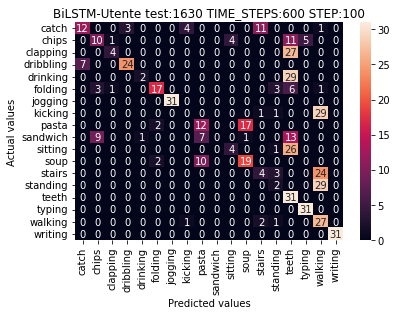

Utente test:  1631
Epoch 1/100
50/50 [==============================] - 21s 256ms/step - loss: 2.6708 - accuracy: 0.1575 - val_loss: 2.3521 - val_accuracy: 0.2567
Epoch 2/100
50/50 [==============================] - 12s 234ms/step - loss: 2.3495 - accuracy: 0.2380 - val_loss: 2.1069 - val_accuracy: 0.3116
Epoch 3/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1976 - accuracy: 0.2795 - val_loss: 1.9575 - val_accuracy: 0.3484
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.0770 - accuracy: 0.3136 - val_loss: 1.8521 - val_accuracy: 0.3765
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 2.2395 - accuracy: 0.2798 - val_loss: 2.0659 - val_accuracy: 0.3262
Epoch 6/100
50/50 [==============================] - 12s 238ms/step - loss: 2.0796 - accuracy: 0.3099 - val_loss: 1.8387 - val_accuracy: 0.3705
Epoch 7/100
50/50 [==============================] - 12s 232ms/step - loss: 1.9787 - accuracy: 0.3361 - val_loss: 1.8

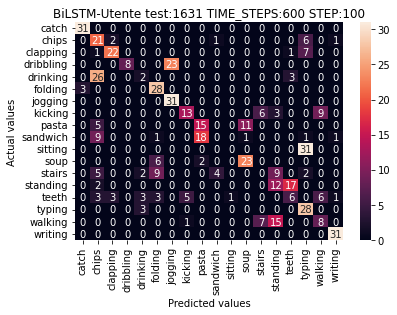

Utente test:  1632
Epoch 1/100
50/50 [==============================] - 20s 263ms/step - loss: 2.6498 - accuracy: 0.1569 - val_loss: 2.3169 - val_accuracy: 0.2713
Epoch 2/100
50/50 [==============================] - 12s 233ms/step - loss: 2.3268 - accuracy: 0.2447 - val_loss: 2.0303 - val_accuracy: 0.3317
Epoch 3/100
50/50 [==============================] - 12s 236ms/step - loss: 2.1434 - accuracy: 0.2952 - val_loss: 1.9417 - val_accuracy: 0.3644
Epoch 4/100
50/50 [==============================] - 12s 237ms/step - loss: 2.0884 - accuracy: 0.3087 - val_loss: 1.9511 - val_accuracy: 0.3587
Epoch 5/100
50/50 [==============================] - 12s 232ms/step - loss: 2.0495 - accuracy: 0.3251 - val_loss: 1.8907 - val_accuracy: 0.3798
Epoch 6/100
50/50 [==============================] - 12s 238ms/step - loss: 1.9609 - accuracy: 0.3448 - val_loss: 1.7687 - val_accuracy: 0.4014
Epoch 7/100
50/50 [==============================] - 12s 237ms/step - loss: 1.9472 - accuracy: 0.3478 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


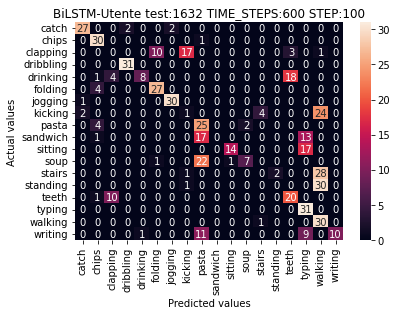

Utente test:  1634
Epoch 1/100
50/50 [==============================] - 21s 262ms/step - loss: 2.6520 - accuracy: 0.1571 - val_loss: 2.3511 - val_accuracy: 0.2479
Epoch 2/100
50/50 [==============================] - 12s 241ms/step - loss: 2.3619 - accuracy: 0.2432 - val_loss: 2.1330 - val_accuracy: 0.2926
Epoch 3/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1466 - accuracy: 0.2881 - val_loss: 1.9144 - val_accuracy: 0.3545
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.0871 - accuracy: 0.3126 - val_loss: 2.0053 - val_accuracy: 0.3495
Epoch 5/100
50/50 [==============================] - 12s 233ms/step - loss: 2.0277 - accuracy: 0.3303 - val_loss: 1.8231 - val_accuracy: 0.3889
Epoch 6/100
50/50 [==============================] - 12s 238ms/step - loss: 1.9716 - accuracy: 0.3493 - val_loss: 1.8685 - val_accuracy: 0.3770
Epoch 7/100
50/50 [==============================] - 12s 231ms/step - loss: 2.0069 - accuracy: 0.3305 - val_loss: 1.7

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


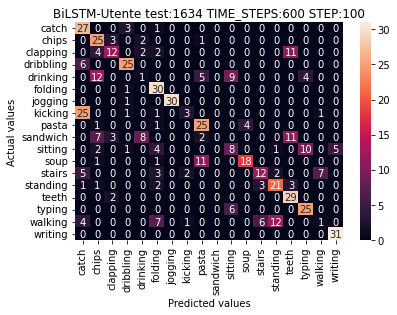

Utente test:  1635
Epoch 1/100
50/50 [==============================] - 21s 263ms/step - loss: 2.6718 - accuracy: 0.1527 - val_loss: 2.3963 - val_accuracy: 0.2452
Epoch 2/100
50/50 [==============================] - 12s 235ms/step - loss: 2.4117 - accuracy: 0.2327 - val_loss: 2.2727 - val_accuracy: 0.2685
Epoch 3/100
50/50 [==============================] - 12s 238ms/step - loss: 2.3391 - accuracy: 0.2454 - val_loss: 2.0726 - val_accuracy: 0.3290
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.1467 - accuracy: 0.2948 - val_loss: 1.9659 - val_accuracy: 0.3539
Epoch 5/100
50/50 [==============================] - 12s 232ms/step - loss: 2.0843 - accuracy: 0.3111 - val_loss: 1.9177 - val_accuracy: 0.3817
Epoch 6/100
50/50 [==============================] - 12s 238ms/step - loss: 2.0417 - accuracy: 0.3200 - val_loss: 1.8789 - val_accuracy: 0.3751
Epoch 7/100
50/50 [==============================] - 12s 238ms/step - loss: 1.9259 - accuracy: 0.3604 - val_loss: 1.7

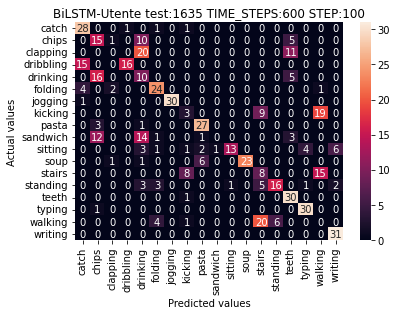

Utente test:  1641
Epoch 1/100
50/50 [==============================] - 21s 259ms/step - loss: 2.6561 - accuracy: 0.1558 - val_loss: 2.3499 - val_accuracy: 0.2591
Epoch 2/100
50/50 [==============================] - 12s 240ms/step - loss: 2.3713 - accuracy: 0.2445 - val_loss: 2.0925 - val_accuracy: 0.3251
Epoch 3/100
50/50 [==============================] - 12s 238ms/step - loss: 2.1767 - accuracy: 0.2958 - val_loss: 1.9656 - val_accuracy: 0.3444
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.0832 - accuracy: 0.3175 - val_loss: 1.9583 - val_accuracy: 0.3561
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 2.0253 - accuracy: 0.3280 - val_loss: 1.8417 - val_accuracy: 0.3787
Epoch 6/100
50/50 [==============================] - 12s 238ms/step - loss: 1.9887 - accuracy: 0.3429 - val_loss: 2.0346 - val_accuracy: 0.3432
Epoch 7/100
50/50 [==============================] - 12s 238ms/step - loss: 2.0001 - accuracy: 0.3287 - val_loss: 1.7

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.3929    0.7333    0.5116        30
           1     0.1212    0.1333    0.1270        30
           2     0.6667    0.1333    0.2222        30
           3     0.2692    0.2333    0.2500        30
           4     0.6154    0.2667    0.3721        30
           5     0.8333    0.5000    0.6250        30
           6     0.8571    1.0000    0.9231        30
           7     0.4524    0.6333    0.5278        30
           8     0.1795    0.2333    0.2029        30
           9     0.0000    0.0000    0.0000        30
          10     1.0000    0.8333    0.9091        30
          11     0.4000    0.8667    0.5474        30
          12     0.3000    0.4000    0.3429        30
          13     0.9524    0.6667    0.7843        30
          14     0.5882    1.0000    0.7407        30
          15     0.9091    1.0000    0.9524        30
          16     0.8571    0.1935    0.3158        31
          17     0.9677    

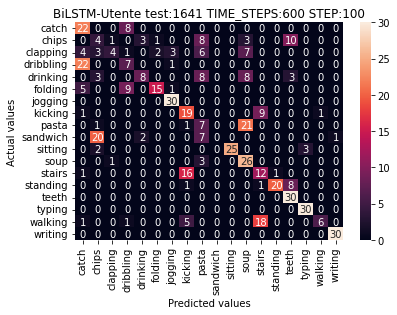

Utente test:  1643
Epoch 1/100
50/50 [==============================] - 22s 263ms/step - loss: 2.6465 - accuracy: 0.1550 - val_loss: 2.3772 - val_accuracy: 0.2469
Epoch 2/100
50/50 [==============================] - 12s 241ms/step - loss: 2.3914 - accuracy: 0.2342 - val_loss: 2.1886 - val_accuracy: 0.2855
Epoch 3/100
50/50 [==============================] - 12s 237ms/step - loss: 2.2628 - accuracy: 0.2630 - val_loss: 2.0587 - val_accuracy: 0.3253
Epoch 4/100
50/50 [==============================] - 12s 236ms/step - loss: 2.1470 - accuracy: 0.2933 - val_loss: 1.9465 - val_accuracy: 0.3421
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 2.1188 - accuracy: 0.2860 - val_loss: 1.9636 - val_accuracy: 0.3349
Epoch 6/100
50/50 [==============================] - 12s 239ms/step - loss: 2.0833 - accuracy: 0.3016 - val_loss: 1.9673 - val_accuracy: 0.3353
Epoch 7/100
50/50 [==============================] - 12s 239ms/step - loss: 2.0413 - accuracy: 0.3121 - val_loss: 2.0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


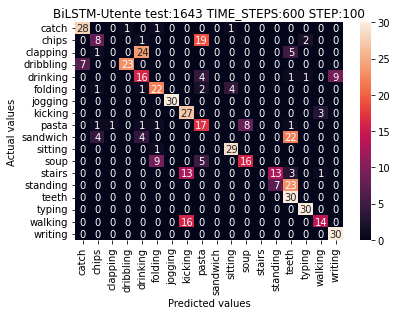

Utente test:  1645
Epoch 1/100
50/50 [==============================] - 20s 260ms/step - loss: 2.6443 - accuracy: 0.1478 - val_loss: 2.3500 - val_accuracy: 0.2597
Epoch 2/100
50/50 [==============================] - 12s 241ms/step - loss: 2.3792 - accuracy: 0.2340 - val_loss: 2.1250 - val_accuracy: 0.3185
Epoch 3/100
50/50 [==============================] - 12s 237ms/step - loss: 2.2392 - accuracy: 0.2681 - val_loss: 2.0375 - val_accuracy: 0.3308
Epoch 4/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1251 - accuracy: 0.2947 - val_loss: 2.0772 - val_accuracy: 0.3086
Epoch 5/100
50/50 [==============================] - 12s 239ms/step - loss: 2.1042 - accuracy: 0.3001 - val_loss: 1.8683 - val_accuracy: 0.3735
Epoch 6/100
50/50 [==============================] - 12s 236ms/step - loss: 2.0014 - accuracy: 0.3254 - val_loss: 1.8608 - val_accuracy: 0.3740
Epoch 7/100
50/50 [==============================] - 12s 232ms/step - loss: 1.9717 - accuracy: 0.3387 - val_loss: 1.7

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


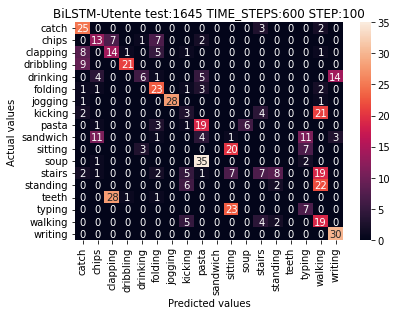

Utente test:  1646
Epoch 1/100
50/50 [==============================] - 20s 258ms/step - loss: 2.6388 - accuracy: 0.1591 - val_loss: 2.3370 - val_accuracy: 0.2623
Epoch 2/100
50/50 [==============================] - 12s 234ms/step - loss: 2.3697 - accuracy: 0.2392 - val_loss: 2.0863 - val_accuracy: 0.3155
Epoch 3/100
50/50 [==============================] - 12s 244ms/step - loss: 2.1623 - accuracy: 0.2865 - val_loss: 1.9466 - val_accuracy: 0.3525
Epoch 4/100
50/50 [==============================] - 12s 242ms/step - loss: 2.0448 - accuracy: 0.3210 - val_loss: 1.8442 - val_accuracy: 0.3741
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 1.9875 - accuracy: 0.3400 - val_loss: 1.7950 - val_accuracy: 0.3928
Epoch 6/100
50/50 [==============================] - 12s 239ms/step - loss: 2.0000 - accuracy: 0.3375 - val_loss: 1.8792 - val_accuracy: 0.3564
Epoch 7/100
50/50 [==============================] - 12s 232ms/step - loss: 1.9600 - accuracy: 0.3361 - val_loss: 1.9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.3673    0.6000    0.4557        30
           1     0.0000    0.0000    0.0000        30
           2     0.4510    0.7667    0.5679        30
           3     0.8333    0.3333    0.4762        30
           4     0.3000    0.1000    0.1500        30
           5     0.5588    0.6333    0.5938        30
           6     1.0000    0.5333    0.6957        30
           7     0.2727    0.1000    0.1463        30
           8     0.0000    0.0000    0.0000        30
           9     0.0000    0.0000    0.0000        30
          10     0.9677    1.0000    0.9836        30
          11     0.2632    0.6667    0.3774        30
          12     0.1429    0.0645    0.0889        31
          13     0.4348    1.0000    0.6061        30
          14     0.8667    0.8667    0.8667        30
          15     0.9375    1.0000    0.9677        30
          16     0.3750    0.5000    0.4286        30
          17     0.7895    

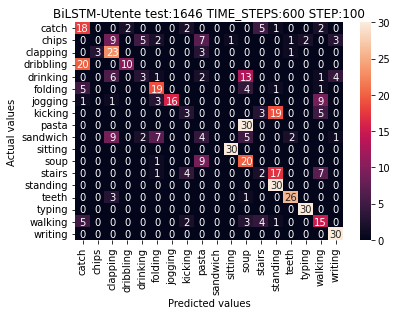

Utente test:  1649
Epoch 1/100
50/50 [==============================] - 21s 264ms/step - loss: 2.6597 - accuracy: 0.1596 - val_loss: 2.3520 - val_accuracy: 0.2728
Epoch 2/100
50/50 [==============================] - 12s 241ms/step - loss: 2.3700 - accuracy: 0.2446 - val_loss: 2.1319 - val_accuracy: 0.3064
Epoch 3/100
50/50 [==============================] - 12s 238ms/step - loss: 2.2100 - accuracy: 0.2699 - val_loss: 1.9852 - val_accuracy: 0.3330
Epoch 4/100
50/50 [==============================] - 12s 238ms/step - loss: 2.1272 - accuracy: 0.3005 - val_loss: 1.8916 - val_accuracy: 0.3536
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 2.0649 - accuracy: 0.3086 - val_loss: 1.9092 - val_accuracy: 0.3586
Epoch 6/100
50/50 [==============================] - 12s 239ms/step - loss: 1.9666 - accuracy: 0.3397 - val_loss: 1.8066 - val_accuracy: 0.3805
Epoch 7/100
50/50 [==============================] - 12s 233ms/step - loss: 1.9540 - accuracy: 0.3478 - val_loss: 1.8

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.7250    0.9667    0.8286        30
           1     0.4576    0.8710    0.6000        31
           2     0.8158    1.0000    0.8986        31
           3     1.0000    1.0000    1.0000        31
           4     0.5455    0.1935    0.2857        31
           5     0.4493    1.0000    0.6200        31
           6     1.0000    1.0000    1.0000        31
           7     0.6000    0.4412    0.5085        34
           8     0.4865    0.5806    0.5294        31
           9     0.0000    0.0000    0.0000        31
          10     1.0000    0.9677    0.9836        31
          11     0.5600    0.4516    0.5000        31
          12     0.3077    0.1290    0.1818        31
          13     0.0000    0.0000    0.0000        31
          14     1.0000    0.8065    0.8929        31
          15     0.6889    1.0000    0.8158        31
          16     0.3953    0.5484    0.4595        31
          17     0.8857    

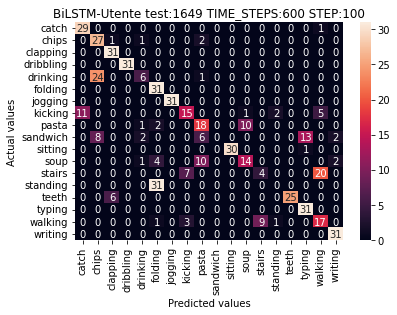

Accuracy media: 0.5325834055892451
F1 media macro: 0.4815873784569739
F1 media weighted: 0.4815873784569739


In [ ]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
          if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if id != user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

              model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
              bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              bilstm_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

              bilstm_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [ ]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

Time Steps  Step  Average accuracy  Average F1 weighted  Average F1 macro  \
0         600   100          0.532583             0.481225          0.481587   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...

# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       1.00      0.77      0.87        31
       chips       0.67      1.00      0.81        31
    clapping       0.91      0.65      0.75        31
   dribbling       0.82      1.00      0.90        31
    drinking       0.57      0.77      0.66        31
     folding       1.00      0.94      0.97        36
     jogging       1.00      1.00      1.00        31
     kicking       1.00      1.00      1.00        31
       pasta       0.47      0.52      0.49        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      1.00      1.00        31
        soup       1.00      0.84      0.91        31
      stairs       1.00      0.94      0.97        31
    standing       1.00      1.00      1.00        31
       teeth       0.63      1.00      0.78        31
      typing       1.00      1.00      1.00        31
     walking       0.94      1.00      0.97        31
     writing       1.00    

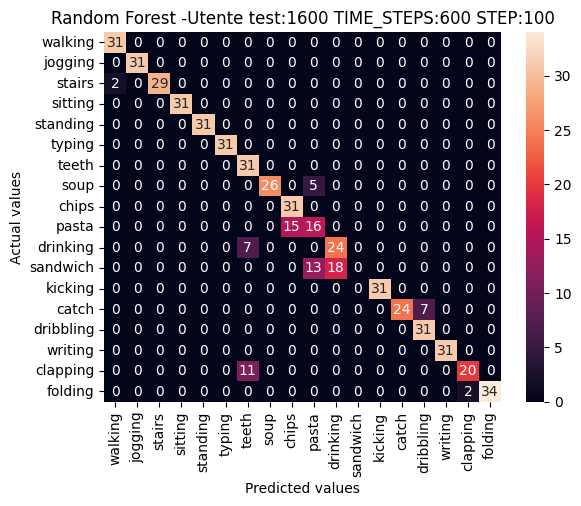

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.9s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       1.00      0.58      0.73        31
       chips       0.83      0.61      0.70        31
    clapping       0.86      0.97      0.91        31
   dribbling       0.61      1.00      0.76        31
    drinking       0.42      1.00      0.59        31
     folding       0.68      0.42      0.52        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.55      0.71        31
       pasta       0.00      0.00      0.00        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.89      1.00      0.94        31
        soup       0.79      1.00      0.89        31
      stairs       0.46      0.94      0.62        31
    standing       1.00      0.68      0.81        31
       teeth       0.96      0.84      0.90        31
      typing       1.00      1.00      1.00        31
     walking       0.91      0.65      0.75        31
     writing       0.60    

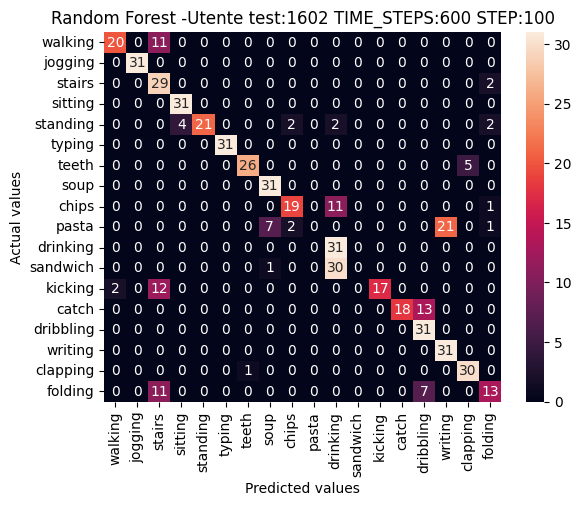

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


              precision    recall  f1-score   support

       catch       1.00      0.87      0.93        31
       chips       0.40      0.97      0.57        31
    clapping       0.97      0.97      0.97        31
   dribbling       0.82      1.00      0.90        31
    drinking       0.93      0.90      0.92        31
     folding       1.00      0.77      0.87        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.45      0.62        31
       pasta       0.55      0.58      0.56        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      1.00      1.00        31
        soup       0.86      0.39      0.53        31
      stairs       0.84      1.00      0.91        31
    standing       1.00      0.19      0.32        31
       teeth       1.00      0.77      0.87        31
      typing       0.91      1.00      0.95        31
     walking       0.65      0.97      0.78        31
     writing       0.58    

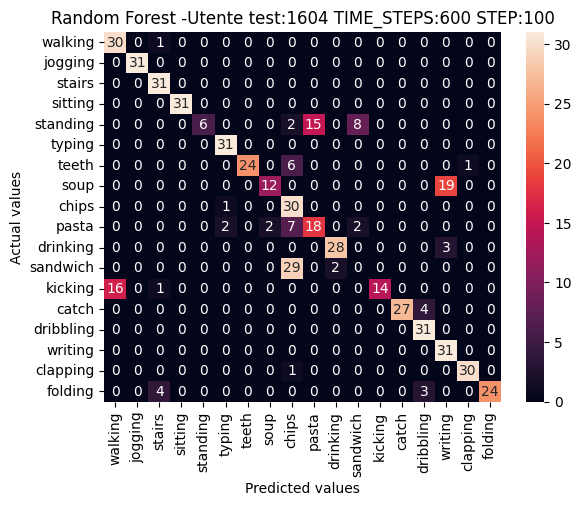

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       1.00      0.61      0.76        31
       chips       0.77      0.77      0.77        44
    clapping       1.00      1.00      1.00        31
   dribbling       0.53      1.00      0.70        31
    drinking       0.85      0.90      0.88        31
     folding       0.91      1.00      0.95        31
     jogging       1.00      0.48      0.65        31
     kicking       1.00      0.71      0.83        31
       pasta       0.76      1.00      0.86        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.00      0.00      0.00        31
        soup       0.55      1.00      0.71        31
      stairs       0.78      1.00      0.87        31
    standing       1.00      0.94      0.97        31
       teeth       1.00      1.00      1.00        31
      typing       0.94      0.97      0.95        31
     walking       1.00      1.00      1.00        31
     writing       1.00    

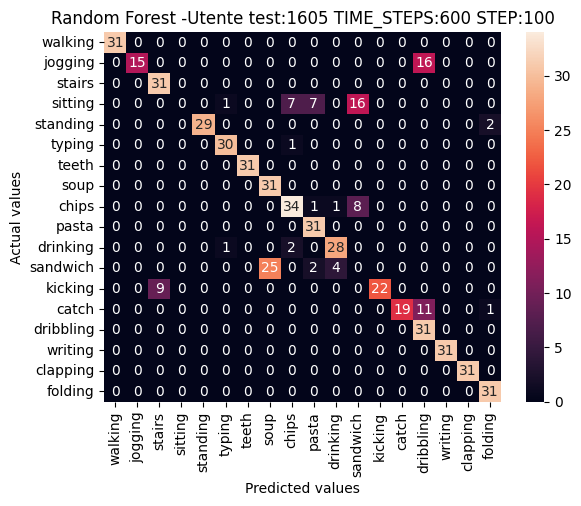

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished


              precision    recall  f1-score   support

       catch       0.86      0.58      0.69        31
       chips       0.97      0.97      0.97        31
    clapping       0.37      0.65      0.47        31
   dribbling       0.75      0.97      0.85        31
    drinking       1.00      0.52      0.68        31
     folding       0.51      0.65      0.57        31
     jogging       0.72      1.00      0.84        31
     kicking       0.73      0.71      0.72        31
       pasta       0.83      0.48      0.61        31
    sandwich       0.86      0.81      0.83        31
     sitting       1.00      1.00      1.00        31
        soup       0.67      0.94      0.78        31
      stairs       0.27      0.19      0.23        31
    standing       1.00      1.00      1.00        31
       teeth       0.48      0.52      0.50        31
      typing       1.00      1.00      1.00        31
     walking       0.60      0.29      0.39        31
     writing       1.00    

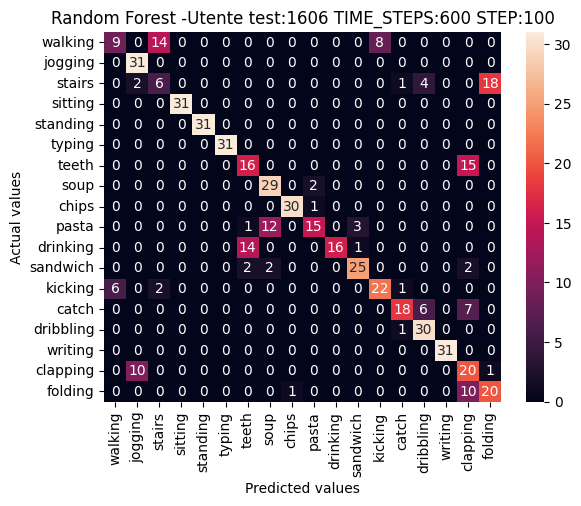

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

       catch       1.00      1.00      1.00        31
       chips       0.38      0.10      0.15        31
    clapping       1.00      1.00      1.00        31
   dribbling       1.00      1.00      1.00        31
    drinking       0.49      1.00      0.66        31
     folding       1.00      1.00      1.00        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.65      0.78        31
       pasta       1.00      0.84      0.91        31
    sandwich       1.00      0.03      0.06        31
     sitting       0.70      1.00      0.83        31
        soup       1.00      1.00      1.00        31
      stairs       0.93      0.87      0.90        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      1.00      1.00        31
      typing       0.62      1.00      0.77        31
     walking       0.68      0.97      0.80        31
     writing       1.00    

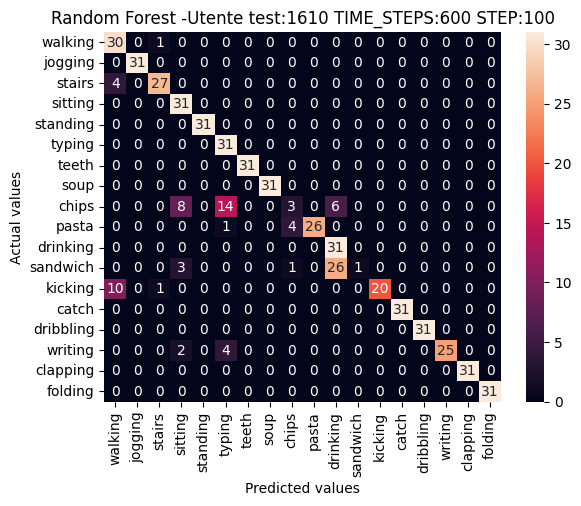

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.1s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       0.06      0.06      0.06        31
       chips       0.49      0.81      0.61        31
    clapping       0.65      0.90      0.76        31
   dribbling       0.52      1.00      0.68        31
    drinking       0.82      1.00      0.90        31
     folding       1.00      0.23      0.37        31
     jogging       1.00      1.00      1.00        31
     kicking       0.96      0.81      0.88        31
       pasta       1.00      1.00      1.00        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.76      0.84      0.80        31
        soup       0.00      0.00      0.00        31
      stairs       1.00      0.90      0.95        31
    standing       1.00      0.42      0.59        31
       teeth       0.32      0.52      0.40        31
      typing       0.89      1.00      0.94        31
     walking       0.79      1.00      0.89        31
     writing       1.00    

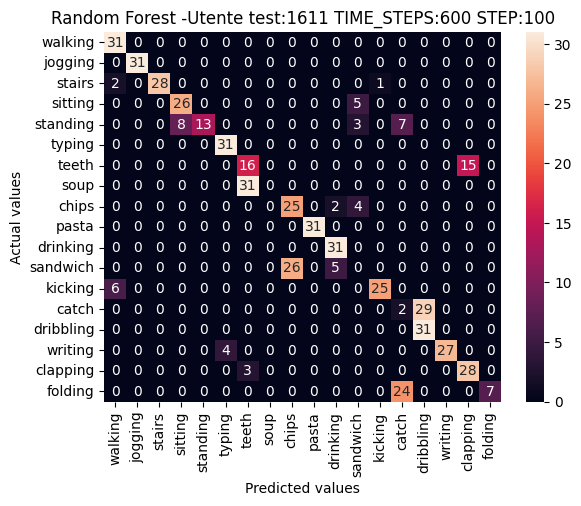

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       catch       0.93      0.90      0.92        31
       chips       0.26      0.42      0.32        31
    clapping       0.91      1.00      0.95        31
   dribbling       1.00      0.19      0.32        31
    drinking       0.14      0.10      0.12        31
     folding       1.00      1.00      1.00        31
     jogging       0.54      1.00      0.70        31
     kicking       0.18      0.06      0.10        31
       pasta       0.57      0.94      0.71        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      1.00      1.00        31
        soup       1.00      1.00      1.00        31
      stairs       1.00      0.68      0.81        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      1.00      1.00        31
      typing       1.00      1.00      1.00        31
     walking       0.53      1.00      0.70        31
     writing       1.00    

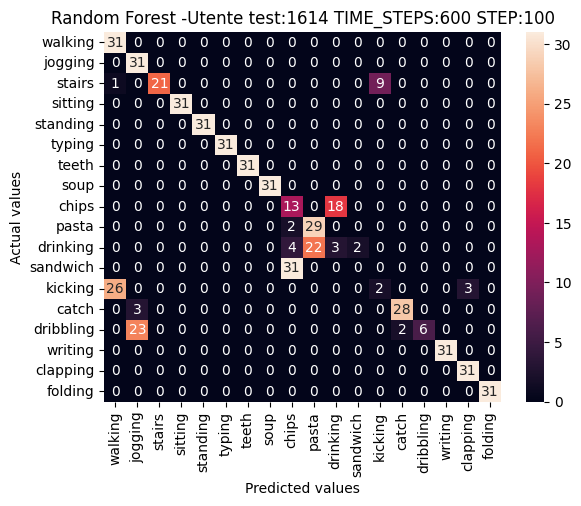

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

       catch       0.90      0.61      0.73        31
       chips       0.44      0.87      0.58        31
    clapping       0.91      1.00      0.95        31
   dribbling       0.53      0.94      0.67        31
    drinking       0.67      0.84      0.74        31
     folding       1.00      0.65      0.78        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.90      0.95        31
       pasta       0.17      0.13      0.15        31
    sandwich       0.44      0.13      0.20        31
     sitting       0.78      1.00      0.87        31
        soup       1.00      0.55      0.71        31
      stairs       0.54      0.90      0.67        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      0.90      0.95        31
      typing       0.89      0.77      0.83        31
     walking       1.00      0.32      0.49        31
     writing       1.00    

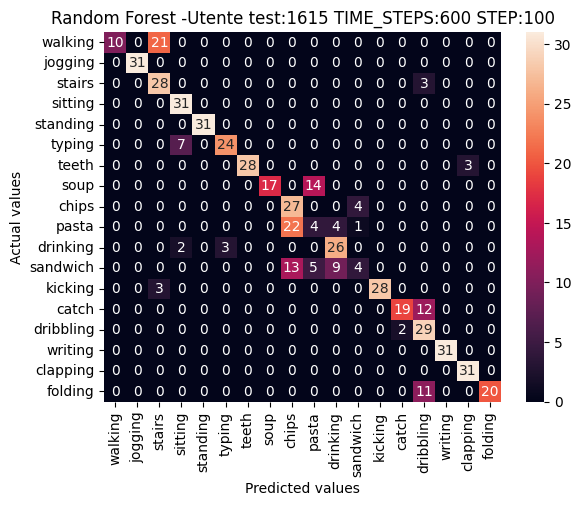

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.5s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       1.00      0.16      0.28        31
       chips       0.23      0.16      0.19        31
    clapping       0.74      1.00      0.85        31
   dribbling       0.53      0.94      0.67        31
    drinking       0.41      1.00      0.58        31
     folding       0.93      0.42      0.58        31
     kicking       1.00      1.00      1.00        31
       pasta       0.82      1.00      0.90        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      0.23      0.37        31
        soup       0.38      0.32      0.35        31
      stairs       0.94      0.97      0.95        31
    standing       1.00      0.84      0.91        31
       teeth       1.00      1.00      1.00        31
      typing       0.61      1.00      0.76        31
     walking       1.00      1.00      1.00        31
     writing       0.78      1.00      0.87        31

    accuracy              

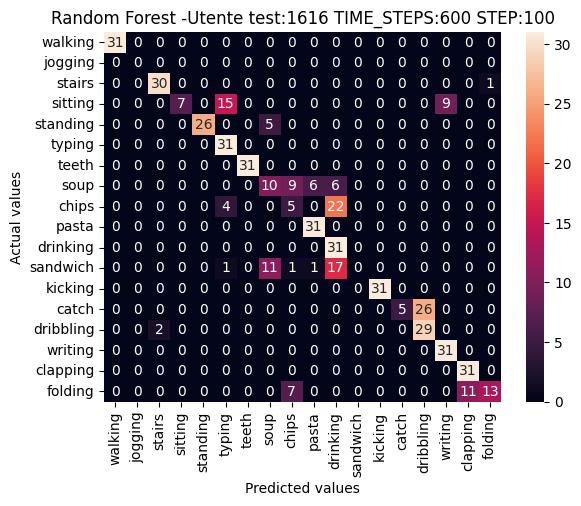

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       1.00      1.00      1.00        31
       chips       1.00      0.94      0.97        31
    clapping       0.47      0.65      0.54        31
   dribbling       0.94      1.00      0.97        31
    drinking       0.86      1.00      0.93        31
     folding       0.82      0.29      0.43        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.84      0.91        31
       pasta       0.42      0.81      0.55        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      1.00      1.00        30
        soup       0.79      1.00      0.89        31
      stairs       0.61      1.00      0.76        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      0.26      0.41        31
      typing       1.00      1.00      1.00        31
     walking       0.86      1.00      0.93        31
     writing       1.00    

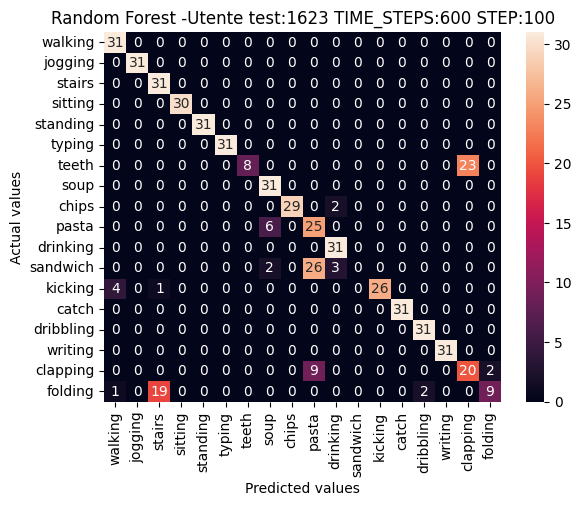

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 144.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished


              precision    recall  f1-score   support

       catch       1.00      0.67      0.80        49
       chips       1.00      0.32      0.49        31
    clapping       1.00      1.00      1.00        31
   dribbling       0.94      1.00      0.97        31
    drinking       0.47      0.87      0.61        31
     folding       1.00      1.00      1.00        31
     jogging       1.00      1.00      1.00        31
     kicking       0.33      0.06      0.11        31
       pasta       0.54      0.45      0.49        31
    sandwich       0.50      0.10      0.16        31
     sitting       0.00      0.00      0.00        31
        soup       0.60      1.00      0.75        31
      stairs       0.89      1.00      0.94        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      1.00      1.00        31
      typing       0.50      1.00      0.67        31
     walking       0.47      1.00      0.64        31
     writing       0.79    

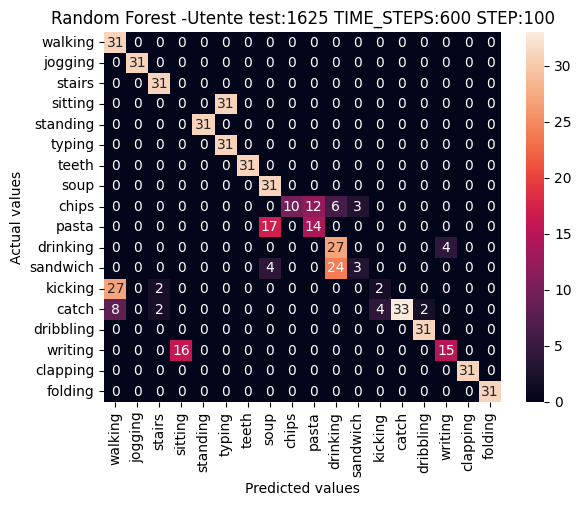

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       catch       1.00      0.90      0.95        31
       chips       0.76      0.61      0.68        31
    clapping       1.00      0.84      0.91        31
   dribbling       1.00      1.00      1.00        31
    drinking       0.91      0.32      0.48        31
     folding       0.97      1.00      0.98        31
     jogging       1.00      0.97      0.98        31
     kicking       1.00      1.00      1.00        31
       pasta       1.00      0.52      0.68        31
    sandwich       0.59      0.84      0.69        31
     sitting       0.97      1.00      0.98        31
        soup       0.83      0.81      0.82        31
      stairs       0.82      1.00      0.90        31
    standing       1.00      1.00      1.00        31
       teeth       0.51      1.00      0.67        31
      typing       0.88      0.97      0.92        31
     walking       1.00      0.87      0.93        31
     writing       1.00    

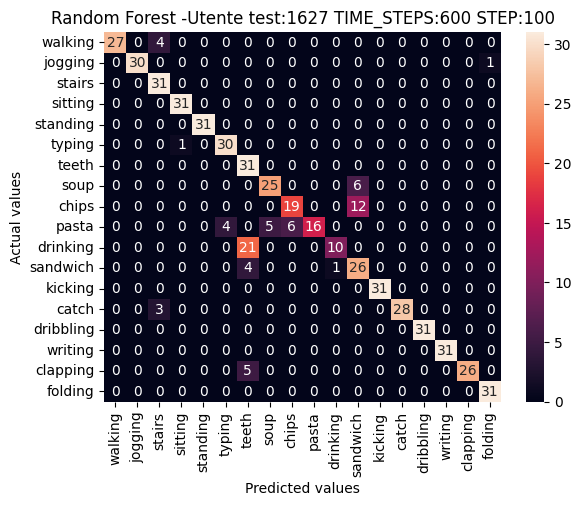

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       catch       0.37      0.55      0.44        31
       chips       0.83      0.94      0.88        31
    clapping       1.00      1.00      1.00        31
   dribbling       0.50      0.06      0.11        31
    drinking       0.62      0.74      0.68        31
     folding       1.00      1.00      1.00        31
     jogging       1.00      1.00      1.00        31
     kicking       0.88      0.94      0.91        31
       pasta       0.36      0.52      0.43        31
    sandwich       0.43      0.19      0.27        31
     sitting       1.00      1.00      1.00        31
        soup       0.35      0.26      0.30        31
      stairs       0.61      0.87      0.72        31
    standing       0.94      1.00      0.97        31
       teeth       1.00      1.00      1.00        31
      typing       1.00      1.00      1.00        31
     walking       0.79      0.71      0.75        31
     writing       1.00    

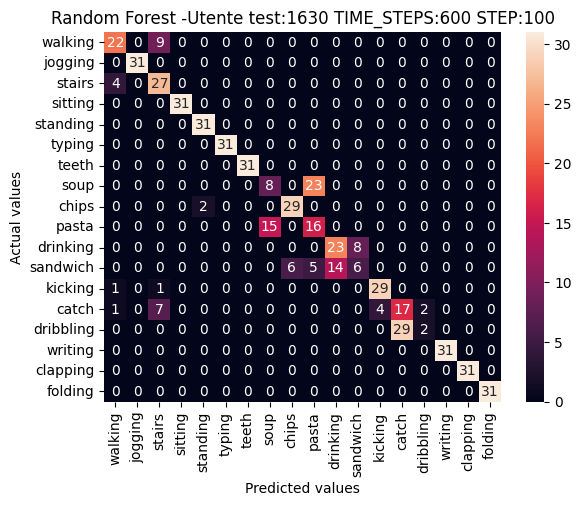

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       catch       1.00      0.65      0.78        31
       chips       0.71      0.87      0.78        31
    clapping       0.76      0.84      0.80        31
   dribbling       1.00      1.00      1.00        31
    drinking       0.62      0.97      0.76        31
     folding       0.48      1.00      0.65        31
     jogging       1.00      1.00      1.00        31
     kicking       0.56      0.87      0.68        31
       pasta       0.58      0.68      0.63        31
    sandwich       1.00      0.03      0.06        31
     sitting       0.48      0.97      0.64        31
        soup       0.79      1.00      0.89        31
      stairs       0.00      0.00      0.00        31
    standing       1.00      1.00      1.00        31
       teeth       0.96      0.71      0.81        31
      typing       0.00      0.00      0.00        31
     walking       0.73      0.26      0.38        31
     writing       0.97    

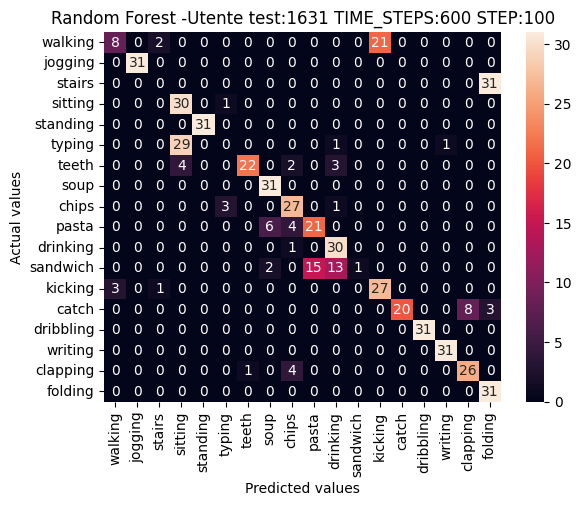

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       0.97      1.00      0.98        31
       chips       0.97      1.00      0.98        31
    clapping       1.00      1.00      1.00        31
   dribbling       1.00      1.00      1.00        31
    drinking       1.00      1.00      1.00        31
     folding       1.00      1.00      1.00        31
     jogging       0.94      1.00      0.97        31
     kicking       1.00      0.65      0.78        31
       pasta       0.56      1.00      0.72        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.94      1.00      0.97        31
        soup       1.00      0.94      0.97        31
      stairs       0.44      1.00      0.61        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      1.00      1.00        31
      typing       0.84      1.00      0.91        31
     walking       0.00      0.00      0.00        31
     writing       1.00    

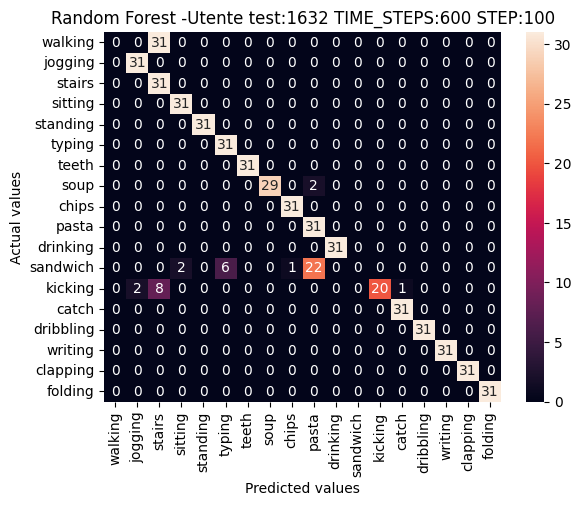

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.7s finished


              precision    recall  f1-score   support

       catch       0.47      0.61      0.54        31
       chips       0.53      1.00      0.70        31
    clapping       0.82      1.00      0.90        31
   dribbling       0.41      0.48      0.44        31
    drinking       0.00      0.00      0.00        31
     folding       0.70      1.00      0.83        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.06      0.12        31
       pasta       1.00      0.97      0.98        31
    sandwich       0.25      0.10      0.14        31
     sitting       0.90      0.29      0.44        31
        soup       0.97      1.00      0.98        31
      stairs       0.62      1.00      0.77        31
    standing       1.00      0.90      0.95        31
       teeth       1.00      0.77      0.87        31
      typing       0.58      1.00      0.74        31
     walking       0.69      0.35      0.47        31
     writing       0.84    

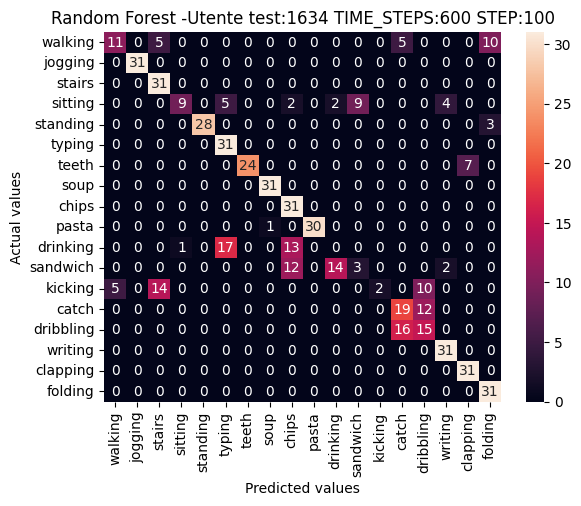

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 23.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

       catch       1.00      0.29      0.45        31
       chips       0.38      1.00      0.55        31
    clapping       1.00      0.48      0.65        31
   dribbling       0.41      0.48      0.44        31
    drinking       0.05      0.03      0.04        31
     folding       0.91      1.00      0.95        31
     jogging       1.00      1.00      1.00        31
     kicking       0.96      0.87      0.92        31
       pasta       0.49      1.00      0.66        31
    sandwich       0.38      0.10      0.15        31
     sitting       1.00      0.23      0.37        31
        soup       0.60      0.10      0.17        31
      stairs       0.57      0.90      0.70        31
    standing       1.00      0.84      0.91        31
       teeth       0.66      1.00      0.79        31
      typing       0.74      1.00      0.85        31
     walking       0.91      0.94      0.92        31
     writing       1.00    

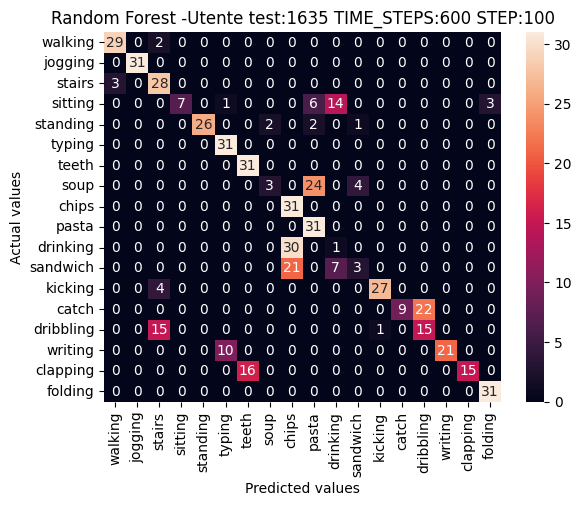

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished


              precision    recall  f1-score   support

       catch       0.79      1.00      0.88        30
       chips       0.06      0.07      0.07        30
    clapping       1.00      0.97      0.98        30
   dribbling       0.96      0.77      0.85        30
    drinking       0.60      0.97      0.74        30
     folding       1.00      0.97      0.98        30
     jogging       1.00      1.00      1.00        30
     kicking       1.00      1.00      1.00        30
       pasta       0.50      0.17      0.25        30
    sandwich       0.00      0.00      0.00        30
     sitting       1.00      0.93      0.97        30
        soup       0.52      0.83      0.64        30
      stairs       0.67      1.00      0.80        30
    standing       1.00      0.90      0.95        30
       teeth       0.94      1.00      0.97        30
      typing       0.94      1.00      0.97        30
     walking       1.00      0.52      0.68        31
     writing       0.91    

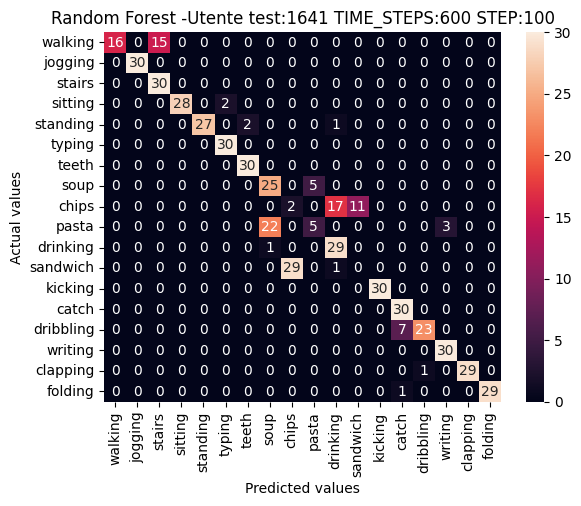

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

       catch       1.00      0.90      0.95        31
       chips       0.72      0.97      0.83        30
    clapping       1.00      0.93      0.97        30
   dribbling       0.97      1.00      0.98        30
    drinking       0.78      1.00      0.87        31
     folding       0.94      1.00      0.97        30
     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.97      0.98        30
       pasta       1.00      1.00      1.00        30
    sandwich       1.00      0.40      0.57        30
     sitting       1.00      0.93      0.97        30
        soup       1.00      1.00      1.00        30
      stairs       1.00      0.57      0.72        30
    standing       1.00      1.00      1.00        30
       teeth       1.00      1.00      1.00        30
      typing       0.91      1.00      0.95        30
     walking       0.68      1.00      0.81        30
     writing       1.00    

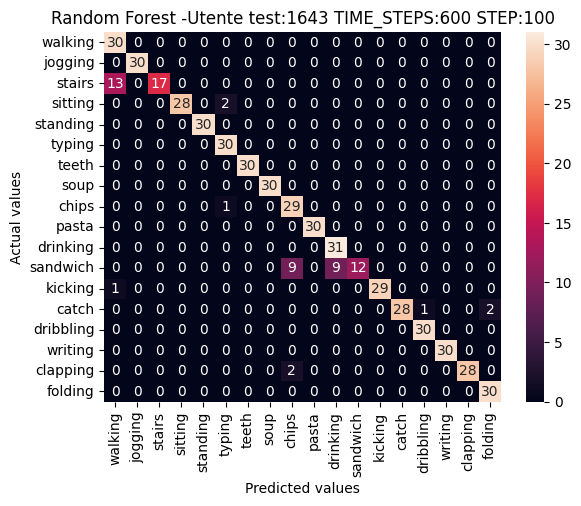

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


              precision    recall  f1-score   support

       catch       0.96      0.80      0.87        30
       chips       0.59      0.80      0.68        30
    clapping       0.50      0.97      0.66        30
   dribbling       0.65      1.00      0.79        30
    drinking       0.65      1.00      0.79        30
     folding       0.78      1.00      0.87        31
     jogging       0.81      1.00      0.90        30
     kicking       1.00      0.63      0.78        30
       pasta       0.36      0.57      0.44        30
    sandwich       0.33      0.06      0.11        31
     sitting       1.00      0.67      0.80        30
        soup       0.24      0.11      0.15        38
      stairs       0.69      0.46      0.55        52
    standing       1.00      1.00      1.00        30
       teeth       1.00      0.03      0.06        30
      typing       0.67      1.00      0.80        30
     walking       0.83      0.80      0.81        30
     writing       1.00    

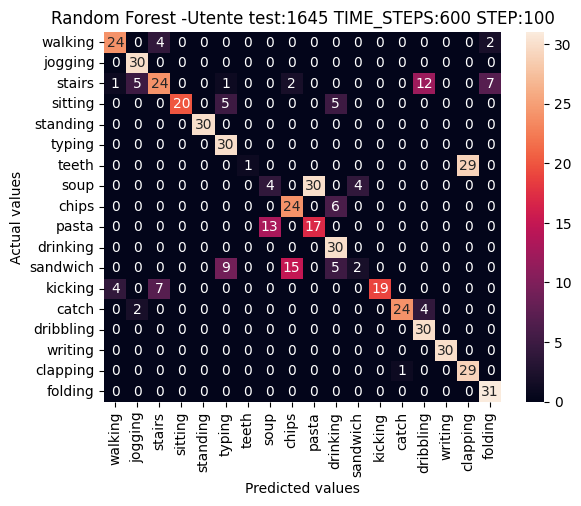

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
c:\Users\Barty\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

       catch       0.59      0.73      0.66        30
       chips       0.67      0.27      0.38        30
    clapping       0.65      1.00      0.79        30
   dribbling       0.73      0.80      0.76        30
    drinking       0.11      0.23      0.15        30
     folding       0.88      0.93      0.90        30
     jogging       1.00      0.77      0.87        30
     kicking       0.97      1.00      0.98        30
       pasta       0.05      0.03      0.04        30
    sandwich       0.00      0.00      0.00        30
     sitting       1.00      0.27      0.42        30
        soup       0.32      0.57      0.41        30
      stairs       0.77      0.97      0.86        31
    standing       0.59      0.97      0.73        30
       teeth       1.00      0.47      0.64        30
      typing       1.00      1.00      1.00        30
     walking       1.00      0.67      0.80        30
     writing       0.94    

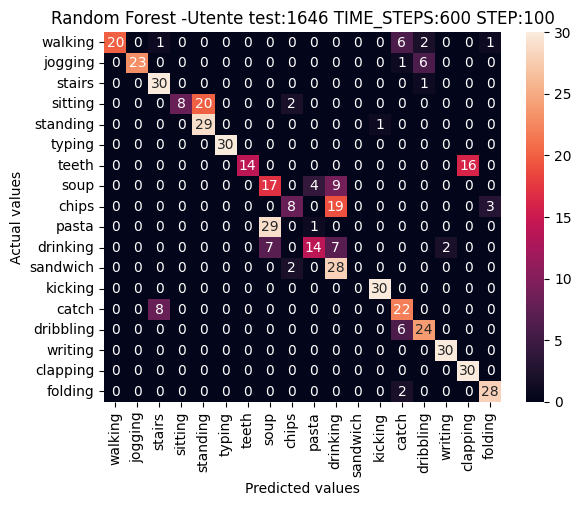

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

       catch       0.67      0.73      0.70        30
       chips       0.45      0.97      0.62        31
    clapping       0.97      1.00      0.98        31
   dribbling       1.00      1.00      1.00        31
    drinking       0.57      0.42      0.48        31
     folding       1.00      1.00      1.00        31
     jogging       1.00      1.00      1.00        31
     kicking       0.91      0.59      0.71        34
       pasta       1.00      0.39      0.56        31
    sandwich       1.00      0.06      0.12        31
     sitting       1.00      1.00      1.00        31
        soup       0.62      1.00      0.77        31
      stairs       0.63      1.00      0.78        31
    standing       1.00      1.00      1.00        31
       teeth       1.00      1.00      1.00        31
      typing       0.97      1.00      0.98        31
     walking       0.82      0.58      0.68        31
     writing       1.00    

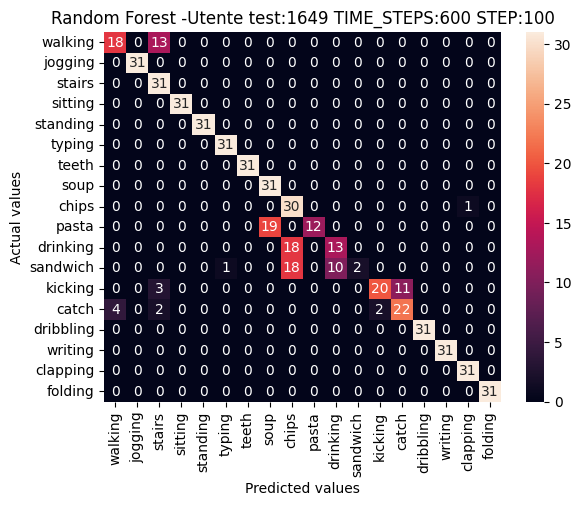

F1 total:  0.7386213622289167
Accuracy total:  0.7657700017725346
   Time Steps  Step  Average accuracy  Average F1
0         600   100           0.76577    0.738621


In [ ]:

from sklearn.ensemble import RandomForestClassifier
import seaborn

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:
      if user_id not in notConsider:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))